# Concept
- Concept: 
    - Webpage where shifter/shift leader can input 
        - The run they want to find a good reference run for
        - Basic requirements for their reference run
        - The runs that they want to consider as candidate reference runs
        - The features they want to be considered in the ranking process
        - Dataset
        - Other advanced options
            - Number of components in PCA (default = 2)
            - Min number of LSs (default = 600)
            - Extra filters on candidate runs
    - Output is a table with
        - Candidate runs ordered by ranking
        - Number of LSs of each run
        - Quick link to OMS and GUI
        - Value of selected features
    - Run number of candidate runs is clickable and clicking it opens a side window which contains the following for the run
        - In/Out components
        - Full OMS metadata
        - Certification notes left by shifter (fetched form Cert Helper)
        - Summary plots
        - Search results for the selected run number (elogs might not have proper API to be able to do this)
    - Ranking of runs will be downloadable/saveable.
    - Tool will be available in the ML Playground

- UI sketch

<!-- ![image-2.png](attachment:image-2.png) -->

# To-do:
- Implement other types of run selection criteria (in addition to just range of runs)

# Setup

In [1]:
# External modules
import pandas as pd
import matplotlib.pyplot as plt
from fnmatch import fnmatch
import seaborn as sns
import importlib
import numpy as np
import os, sys
import json
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.options.mode.chained_assignment = None

In [2]:
# Local modules
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../utils/'))

import get_oms_data
from get_oms_data import get_oms_api, get_oms_data, get_oms_response_attribute

import json_utils as jsonu
from refruns_utils import get_reference
import rank_utils as rrr
import oms_utils as omsu
import rrrtests as tests

In [3]:
# sns version higher than 0.11 are not compatible with this notebook
sns.__version__

'0.11.2'

In [4]:
importlib.reload(rrr)
importlib.reload(omsu)
importlib.reload(tests)

<module 'rrrtests' from '/eos/home-i02/r/rcruzcan/SWAN_projects/RefRunRank/utils/rrrtests.py'>

# User Input
(Note: Implementation will first focus on only run level info. LS level info will be used afterwards as an optional enhancement in the ranking)
- Full selection of run level and LS level features

In [3]:
# Initializing oms api
omsapi = get_oms_api()

In [33]:
# Using the API, you can check all of the available features
print("All available run level features:\n")
get_oms_data(omsapi, "runs", 316201, limit_entries=1)["data"][0]["attributes"]

All available run level features:

https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][EQ]=316201&page[offset]=0&page[limit]=1
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][EQ]=316201&page[offset]=0&page[limit]=1


{'components': ['CSC',
  'CTPPS',
  'CTPPS_TOT',
  'DAQ',
  'DCS',
  'DQM',
  'DT',
  'ECAL',
  'ES',
  'HCAL',
  'PIXEL',
  'RPC',
  'SCAL',
  'TCDS',
  'TRACKER',
  'TRG'],
 'l1_hlt_mode_stripped': 'collisions2018/v104',
 'l1_key': 'l1_trg_collisions2018/v20',
 'duration': 11652,
 'b_field': 3.801,
 'tier0_transfer': True,
 'l1_triggers_counter': 688298338,
 'hlt_physics_throughput': 0.51592051,
 'init_lumi': 1.08030703125,
 'era': '2018A',
 'last_update': '2018-05-13T06:54:17Z',
 'components_out': ['CASTOR', 'GEM'],
 'beamactive_total_deadtime': 6.92,
 'recorded_lumi': 105.89309375,
 'delivered_lumi': 113.15528125,
 'cmssw_version': 'CMSSW_10_1_4',
 'crossing_angle_stop': 160.0,
 'energy': 6499.0,
 'end_lumi': 0.846014355469,
 'hlt_physics_rate': 793.303,
 'fill_number': 6675,
 'l1_hlt_mode': 'collisions2018',
 'end_time': '2018-05-13T05:49:52Z',
 'trigger_mode': 'l1_hlt_collisions2018/v104',
 'l1_key_stripped': 'collisions2018/v20',
 'crossing_angle_start': 160.0,
 'fill_type_party

In [8]:
# LS level features are not yet included
print("All available LS level features:\n")
get_oms_data(omsapi, "lumisections", 316201, limit_entries=1)["data"][0]["attributes"]

All available LS level features:

https://vocms0185.cern.ch/agg/api/v1/lumisections/?filter[run_number][EQ]=316201&page[offset]=0&page[limit]=1
https://vocms0185.cern.ch/agg/api/v1/lumisections/?filter[run_number][EQ]=316201&page[offset]=0&page[limit]=1


{'beam1_present': True,
 'bpix_ready': True,
 'ho_ready': True,
 'dtp_ready': True,
 'tecm_ready': True,
 'delivered_lumi_per_lumisection': 0.220375,
 'recorded_lumi_per_lumisection': 0.04540625,
 'castor_ready': False,
 'init_lumi': 1.08030703125,
 'hbhea_ready': True,
 'recorded_lumi': 390.6043125,
 'prescale_name': '1.2e34',
 'dtm_ready': True,
 'end_lumi': 1.079988183594,
 'beams_stable': True,
 'esm_ready': True,
 'gemm_ready': None,
 'ebp_ready': True,
 'cscm_ready': True,
 'start_time': '2018-05-13T02:36:33Z',
 'beam1_stable': True,
 'hbhec_ready': True,
 'rp_time_ready': None,
 'cscp_ready': True,
 'physics_flag': True,
 'dt0_ready': True,
 'gem_ready': None,
 'lumisection_number': 1,
 'tibtid_ready': True,
 'fpix_ready': True,
 'rpc_ready': True,
 'rp_sect_56_ready': None,
 'pileup': 30.22092056,
 'esp_ready': True,
 'eep_ready': True,
 'ebm_ready': True,
 'delivered_lumi': 408.32821875,
 'gemp_ready': None,
 'eem_ready': True,
 'fill_number': 6675,
 'beam_present': True,
 'te

In [5]:
# Full feature list
fullftr_lst = [
    'components',
    'l1_hlt_mode_stripped',
    'l1_key',
    'duration',
    'b_field',
    'tier0_transfer',
    'l1_triggers_counter',
    'hlt_physics_throughput',
    'init_lumi',
    'era',
    'last_update',
    'components_out',
    'beamactive_total_deadtime',
    'recorded_lumi',
    'delivered_lumi',
    'cmssw_version',
    'crossing_angle_stop',
    'energy',
    'end_lumi',
    'hlt_physics_rate',
    'fill_number',
    'l1_hlt_mode',
    'end_time',
    'trigger_mode',
    'l1_key_stripped',
    'crossing_angle_start',
    'fill_type_party2',
    'fill_type_party1',
    'beta_star_start',
    'initial_prescale_index',
    'sequence',
    'start_time',
    'hlt_physics_size',
    'fill_type_runtime',
    'hlt_key',
    'clock_type',
    'last_lumisection_number',
    'l1_rate',
    'l1_menu',
    'run_number',
    'stable_beam',
    'beta_star_stop',
    'hlt_physics_counter'
]

In [6]:
# Numeric features, compatible with PCA
# Comment out features you don't want considered
ftrs_lst = [
    'b_field',
#     'l1_triggers_counter',
#     'hlt_physics_throughput',
    'init_lumi',
#     'beamactive_total_deadtime',
#     'recorded_lumi',
#     'delivered_lumi',
#     'crossing_angle_stop',
    'energy',
    'end_lumi',
    'hlt_physics_rate',
#     'crossing_angle_start',
#     'beta_star_start',
#     'initial_prescale_index',
#     'hlt_physics_size',
    'l1_rate',
    'run_number',
#     'beta_star_stop',
#     'hlt_physics_counter',
    # 'fill_number', # Included for filtering
    # 'last_lumisection_number', # Not for ranking
    # 'duration', # Not for ranking
    # "l1_hlt_mode" # Included for filtering
]

In [4]:
# Loading all available datasets to choose from
with open("../jsons/AllRunsRefRuns_Mar5_2024.json") as f:
    run_info = json.load(f)
    run_info = pd.DataFrame(run_info)
run_info.dropna(inplace=True)
run_info

,run_number,run_reconstruction_type,reference_run_number,reference_run_reconstruction_type,dataset
0,313098,express,312727,express,To Be Defined
1,313106,express,312727,express,To Be Defined
2,313108,express,312727,express,To Be Defined
3,313118,express,312727,express,To Be Defined
4,313120,express,312727,express,To Be Defined
...,...,...,...,...,...
10443,377251,prompt,377127,prompt,/PromptReco/Cosmics2024/DQM
10444,377254,prompt,377127,prompt,/PromptReco/Cosmics2024/DQM
10445,377255,prompt,377127,prompt,/PromptReco/Cosmics2024/DQM
10446,377295,prompt,377127,prompt,/PromptReco/Cosmics2024/DQM


In [5]:
run_info.tail(100)

,run_number,run_reconstruction_type,reference_run_number,reference_run_reconstruction_type,dataset
10348,376939,express,376826,express,/Express/Cosmics2024/DQM
10349,376874,prompt,376826,prompt,/PromptReco/Cosmics2024/DQM
10350,376981,express,376826,express,/Express/Cosmics2024/DQM
10351,376860,prompt,376826,prompt,/PromptReco/Cosmics2024/DQM
10352,376862,prompt,376826,prompt,/PromptReco/Cosmics2024/DQM
...,...,...,...,...,...
10443,377251,prompt,377127,prompt,/PromptReco/Cosmics2024/DQM
10444,377254,prompt,377127,prompt,/PromptReco/Cosmics2024/DQM
10445,377255,prompt,377127,prompt,/PromptReco/Cosmics2024/DQM
10446,377295,prompt,377127,prompt,/PromptReco/Cosmics2024/DQM


In [8]:
candidate_selection = "dataset"

if candidate_selection == "run_range":
    oldest_run = int(input("Oldest run: ")) # Suggestion: 308800
    newest_run = int(input("Newest run: ")) # Suggestion: 326201
    run_range = (oldest_run, newest_run)
elif candidate_selection == "dataset":
    dataset = input("Dataset name (wildcards accepted): ") # E.g.: /Express/Collisions202?/*
    print("Dataset pattern selected: " + dataset)
elif candidate_selection == "range_range":
    pass
elif candidate_selection == "runs":
    pass
elif candidate_selection == "date":
    pass
elif candidate_selection == "era":
    pass
else:
    raise NameError("Invalid candidate selection option selected")

Dataset pattern selected: /Express/Collisions202?/*


In [9]:
selected_datasets = list(set([name for name in run_info["dataset"] if fnmatch(name, dataset)]))
selected_datasets

['/Express/Collisions2022/DQM', '/Express/Collisions2023/DQM']

In [10]:
# Number of PCA components
num_components = 2

# Runs used in ranking will need to have at least this run quality score
# quality_thrshld = 0.75

# Features used will have to have weights that add up to at least this number
weight_thrshld = 1

# Features that have a correlation higher than this with another feature will be dropped
corr_thrshld = 1

# Least number of lumisections
lumi_limit = 500

# Run type
run_type = "collisions"
# for dataset in selected_datasets:
#     if "collisions" not in dataset.lower():
#         print("WARNING: Discrepancy between run type and datasets selected")

# If testing or not
testing = True

In [11]:
# Getting the run number of the runs that will be used
selected_runs_info = run_info[run_info["dataset"].isin(selected_datasets)]
candidate_runnums = np.array(selected_runs_info["run_number"])
candidate_runnums

array([355407, 355417, 356446, 356529, 355418, 355411, 355100, 355104,
       355208, 355133, 355112, 355113, 355134, 355203, 355105, 355106,
       355107, 355108, 355109, 355111, 355110, 355117, 355118, 355119,
       355204, 355205, 355206, 355207, 355101, 355102, 355135, 355414,
       355419, 355374, 355375, 355376, 355379, 355380, 355381, 355382,
       355383, 355404, 355405, 355445, 355429, 355441, 355454, 355456,
       355442, 355437, 355438, 355439, 355444, 355455, 355435, 355443,
       355558, 355559, 355463, 355457, 355679, 355680, 355913, 355921,
       355768, 355769, 355865, 355862, 355863, 355872, 355892, 355912,
       355933, 355942, 355988, 355991, 355993, 356003, 356005, 355989,
       356048, 356046, 356043, 356004, 356047, 356001, 356002, 356071,
       356073, 356075, 356076, 355990, 355992, 355994, 356074, 356077,
       356135, 356164, 356165, 356309, 356316, 356321, 356436, 356323,
       356371, 356375, 356377, 356378, 356381, 356383, 356384, 356385,
      

In [12]:
# Filters that will be applied in query
run_filters = [
    {"attribute_name": "l1_hlt_mode", "value": run_type, "operator": "LIKE"}, # Only collision runs
    {"attribute_name": "last_lumisection_number", "value": lumi_limit, "operator": "GE"},
    # {"attribute_name": "run_number", "value": run_range[0], "operator": "GE"},
    # {"attribute_name": "run_number", "value": run_range[1], "operator": "LE"},
]

# Fetching Data

In [25]:
# Downloading candidate data
# omsu.download_oms_data(355407, omsapi, "runs")
data = get_oms_data(omsapi, "runs", (377254, 377296))
data

https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=377254&filter[run_number][LE]=377296&page[offset]=0&page[limit]=1000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=377254&filter[run_number][LE]=377296&page[offset]=0&page[limit]=1000


{'data': [{'id': '377254',
   'type': 'runs',
   'attributes': {'components': ['CSC',
     'DAQ',
     'DCS',
     'DQM',
     'DT',
     'ECAL',
     'ES',
     'GEM',
     'HCAL',
     'PIXEL',
     'TCDS',
     'TRACKER',
     'TRG'],
    'l1_hlt_mode_stripped': 'cosmics2024/v15',
    'l1_key': 'l1_trg_cosmics2024/v4',
    'duration': 1525,
    'b_field': 3.8,
    'tier0_transfer': True,
    'l1_triggers_counter': 151817843,
    'hlt_physics_throughput': 0.01755084,
    'init_lumi': 0.0,
    'era': 'Commissioning2024',
    'last_update': '2024-02-29T23:07:09Z',
    'components_out': ['CTPPS', 'CTPPS_TOT', 'L1SCOUT', 'RPC'],
    'beamactive_total_deadtime': 0,
    'recorded_lumi': 0.0,
    'delivered_lumi': 0.0,
    'cmssw_version': 'CMSSW_13_3_2_patch1',
    'crossing_angle_stop': None,
    'energy': 7101.0,
    'end_lumi': 0.0,
    'hlt_physics_rate': 190.062,
    'fill_number': 9322,
    'l1_hlt_mode': 'cosmics2024',
    'end_time': '2024-02-29T23:04:48Z',
    'trigger_mode': 'l1_

In [29]:
data["data"][0]["attributes"]

{'components': ['CSC',
  'DAQ',
  'DCS',
  'DQM',
  'DT',
  'ECAL',
  'ES',
  'GEM',
  'HCAL',
  'PIXEL',
  'TCDS',
  'TRACKER',
  'TRG'],
 'l1_hlt_mode_stripped': 'cosmics2024/v15',
 'l1_key': 'l1_trg_cosmics2024/v4',
 'duration': 1525,
 'b_field': 3.8,
 'tier0_transfer': True,
 'l1_triggers_counter': 151817843,
 'hlt_physics_throughput': 0.01755084,
 'init_lumi': 0.0,
 'era': 'Commissioning2024',
 'last_update': '2024-02-29T23:07:09Z',
 'components_out': ['CTPPS', 'CTPPS_TOT', 'L1SCOUT', 'RPC'],
 'beamactive_total_deadtime': 0,
 'recorded_lumi': 0.0,
 'delivered_lumi': 0.0,
 'cmssw_version': 'CMSSW_13_3_2_patch1',
 'crossing_angle_stop': None,
 'energy': 7101.0,
 'end_lumi': 0.0,
 'hlt_physics_rate': 190.062,
 'fill_number': 9322,
 'l1_hlt_mode': 'cosmics2024',
 'end_time': '2024-02-29T23:04:48Z',
 'trigger_mode': 'l1_hlt_cosmics2024/v15',
 'l1_key_stripped': 'cosmics2024/v4',
 'crossing_angle_start': None,
 'fill_type_party2': 'PROTON',
 'fill_type_party1': 'PROTON',
 'beta_star_sta

In [52]:
# Fetching runs that will be used as candidates
candidates_df = omsu.download_oms_data(run_range, omsapi, "runs", extrafilters=run_filters).drop(columns=["index"])

# Filtering run
candidates_df = rrr.filter_runs(candidates_df, "collisions2018", json_name="json_TRK_PromptReco_2018Runs.json")

# Creating a run number index column as an identifier of each run. Note that this is not being treated as a feature the same way run_number is
candidates_df["run"] = candidates_df["run_number"]
candidates_df.set_index("run", inplace=True)

# Removing any non-numeric features left
# candidates_df = candidates_df.select_dtypes(["number"])

# Making index column integer type
candidates_df.index = candidates_df.index.astype(int)

candidates_df

https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=308800&filter[run_number][LE]=313799&filter[l1_hlt_mode][LIKE]=collisions&filter[last_lumisection_number][GE]=500&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=308800&filter[run_number][LE]=313799&filter[l1_hlt_mode][LIKE]=collisions&filter[last_lumisection_number][GE]=500&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=313800&filter[run_number][LE]=318799&filter[l1_hlt_mode][LIKE]=collisions&filter[last_lumisection_number][GE]=500&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=313800&filter[run_number][LE]=318799&filter[l1_hlt_mode][LIKE]=collisions&filter[last_lumisection_number][GE]=500&page[offset]=0&page[limit]=5000


/eos/home-r/rcruzcan/SWAN_projects/RefRunRank/utils/oms_utils.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  oms_df = pd.concat([oms_df, rrr.makeDF(oms_json).convert_dtypes()])
/eos/home-r/rcruzcan/SWAN_projects/RefRunRank/utils/oms_utils.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  oms_df = pd.concat([oms_df, rrr.makeDF(oms_json).convert_dtypes()])


https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=318800&filter[run_number][LE]=323799&filter[l1_hlt_mode][LIKE]=collisions&filter[last_lumisection_number][GE]=500&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=318800&filter[run_number][LE]=323799&filter[l1_hlt_mode][LIKE]=collisions&filter[last_lumisection_number][GE]=500&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=323800&filter[run_number][LE]=326201&filter[l1_hlt_mode][LIKE]=collisions&filter[last_lumisection_number][GE]=500&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=323800&filter[run_number][LE]=326201&filter[l1_hlt_mode][LIKE]=collisions&filter[last_lumisection_number][GE]=500&page[offset]=0&page[limit]=5000


,run_number,components,l1_hlt_mode_stripped,l1_key,duration,b_field,tier0_transfer,l1_triggers_counter,hlt_physics_throughput,init_lumi,...,hlt_physics_size,fill_type_runtime,hlt_key,clock_type,last_lumisection_number,l1_rate,l1_menu,stable_beam,beta_star_stop,hlt_physics_counter
run,,,,,,,,,,,,,,,,,,,,,
314650,314650,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v26,l1_trg_collisions2018/v2,15497,3.801,True,735698016,1.942422,0.005088,...,30065.032,PROTONS,/cdaq/physics/firstCollisions18/v1.5/HLT/V2,LHC,664,47532.402,L1Menu_Collisions2018_0_0_1,True,30,46091399
314663,314663,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v26,l1_trg_collisions2018/v2,12105,3.801,True,556284358,1.39717,0.003219,...,16870.538,PROTONS,/cdaq/physics/firstCollisions18/v1.5/HLT/V2,LHC,518,46070.746,L1Menu_Collisions2018_0_0_1,True,30,34852633
314759,314759,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v31,l1_trg_collisions2018/v2,15889,3.801,True,484768670,1.91867,0.030177,...,30323.532,PROTONS,/cdaq/physics/firstCollisions18/v1.6/HLT/V12,LHC,680,30673.49,L1Menu_Collisions2018_0_0_1,True,30,48337965
314811,314811,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v35,l1_trg_collisions2018/v4,18515,3.801,True,559434193,1.902651,0.034028,...,35126.444,PROTONS,/cdaq/physics/firstCollisions18/v1.6/HLT/V12,LHC,793,30302.76,L1Menu_Collisions2018_0_0_1,True,30,55770974
314816,314816,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v35,l1_trg_collisions2018/v4,25526,3.801,True,773634228,2.404326,0.03509,...,61258.075,PROTONS,/cdaq/physics/firstCollisions18/v1.6/HLT/V12,LHC,1093,30365.01,L1Menu_Collisions2018_0_0_1,True,<NA>,77112230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324980,324980,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v225,l1_trg_collisions2018/v70,54784,3.8,True,4066709762,0.757486,1.859775,...,41477.034,PROTONS,/cdaq/physics/Run2018/2e34/v3.6.1/HLT/V2,LHC,2351,74270.96,L1Menu_Collisions2018_v2_1_0,True,<NA>,56423227
325001,325001,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v225,l1_trg_collisions2018/v70,14078,3.8,True,1094244021,0.531525,1.031316,...,7471.209,PROTONS,/cdaq/physics/Run2018/2e34/v3.6.1/HLT/V2,LHC,603,77849.35,L1Menu_Collisions2018_v2_1_0,True,30,11859168
325022,325022,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v225,l1_trg_collisions2018/v70,37424,3.8,True,2346413454,1.103428,1.889829,...,41257.043,PROTONS,/cdaq/physics/Run2018/2e34/v3.6.1/HLT/V2,LHC,1605,62756.383,L1Menu_Collisions2018_v2_1_0,True,<NA>,50809855


In [70]:
candidates_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 314650 to 325170
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   run_number                 192 non-null    Int64  
 1   components                 192 non-null    object 
 2   l1_hlt_mode_stripped       192 non-null    string 
 3   l1_key                     192 non-null    string 
 4   duration                   192 non-null    Int64  
 5   b_field                    192 non-null    Float64
 6   tier0_transfer             192 non-null    boolean
 7   l1_triggers_counter        192 non-null    Int64  
 8   hlt_physics_throughput     192 non-null    Float64
 9   init_lumi                  192 non-null    Float64
 10  era                        192 non-null    string 
 11  last_update                192 non-null    string 
 12  components_out             192 non-null    object 
 13  beamactive_total_deadtime  192 non-null    Floa

In [55]:
######## For testing, we also get all of the runs in the selected range. #########
targets_df = omsu.download_oms_data(run_range, omsapi, "runs", extrafilters=[run_filters[0]]).drop(columns=["index"])

targets_df = rrr.filter_runs(targets_df, "collisions2018", json_name="json_TRK_PromptReco_2018Runs.json") # Fails to filter by run quality

# Creating a run number index column as an identifier of each run. Note that this is not being treated as a feature the same way run_number is
targets_df["run"] = targets_df["run_number"]
targets_df.set_index("run", inplace=True)

# Removing any non-numeric features left
# targets_df = targets_df.select_dtypes(["number"])

# Making index column type int
targets_df.index = targets_df.index.astype(int)

targets_df

https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=308800&filter[run_number][LE]=313799&filter[l1_hlt_mode][LIKE]=collisions&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=308800&filter[run_number][LE]=313799&filter[l1_hlt_mode][LIKE]=collisions&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=313800&filter[run_number][LE]=318799&filter[l1_hlt_mode][LIKE]=collisions&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=313800&filter[run_number][LE]=318799&filter[l1_hlt_mode][LIKE]=collisions&page[offset]=0&page[limit]=5000


/eos/home-r/rcruzcan/SWAN_projects/RefRunRank/utils/oms_utils.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  oms_df = pd.concat([oms_df, rrr.makeDF(oms_json).convert_dtypes()])
/eos/home-r/rcruzcan/SWAN_projects/RefRunRank/utils/oms_utils.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  oms_df = pd.concat([oms_df, rrr.makeDF(oms_json).convert_dtypes()])


https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=318800&filter[run_number][LE]=323799&filter[l1_hlt_mode][LIKE]=collisions&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=318800&filter[run_number][LE]=323799&filter[l1_hlt_mode][LIKE]=collisions&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=323800&filter[run_number][LE]=326201&filter[l1_hlt_mode][LIKE]=collisions&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][GE]=323800&filter[run_number][LE]=326201&filter[l1_hlt_mode][LIKE]=collisions&page[offset]=0&page[limit]=5000


,run_number,components,l1_hlt_mode_stripped,l1_key,duration,b_field,tier0_transfer,l1_triggers_counter,hlt_physics_throughput,init_lumi,...,hlt_physics_size,fill_type_runtime,hlt_key,clock_type,last_lumisection_number,l1_rate,l1_menu,stable_beam,beta_star_stop,hlt_physics_counter
run,,,,,,,,,,,,,,,,,,,,,
314472,314472,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v22,l1_trg_collisions2018/v2,2005,3.801,True,70776243,0.744635,0.001623,...,1458.05,PROTONS,/cdaq/physics/firstCollisions18/v1.4/HLT/V1,LHC,85,36146.52,L1Menu_Collisions2018_0_0_1,True,30,3230527
314473,314473,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v22,l1_trg_collisions2018/v2,333,3.801,True,11880621,2.398515,0.001552,...,726.835,PROTONS,/cdaq/physics/firstCollisions18/v1.4/HLT/V1,LHC,13,39206.13,L1Menu_Collisions2018_0_0_1,True,30,878868
314474,314474,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v22,l1_trg_collisions2018/v2,323,3.801,True,11676022,2.076845,0.001525,...,580.945,PROTONS,/cdaq/physics/firstCollisions18/v1.4/HLT/V1,LHC,12,41741.863,L1Menu_Collisions2018_0_0_1,True,30,863231
314475,314475,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v22,l1_trg_collisions2018/v2,335,3.801,True,11826829,2.004362,0.001506,...,607.392,PROTONS,/cdaq/physics/firstCollisions18/v1.4/HLT/V1,LHC,13,39028.61,L1Menu_Collisions2018_0_0_1,True,30,874296
314476,314476,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v22,l1_trg_collisions2018/v2,309,3.801,True,11263824,2.173781,0.001466,...,608.061,PROTONS,/cdaq/physics/firstCollisions18/v1.4/HLT/V1,LHC,12,40268.25,L1Menu_Collisions2018_0_0_1,True,30,832912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325168,325168,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v227,l1_trg_collisions2018/v70,454,3.8,True,29746991,0.785135,1.331723,...,329.433,PROTONS,/cdaq/physics/Run2018/2e34/v3.6.1/HLT/V2,LHC,21,70897.14,L1Menu_Collisions2018_v2_1_0,True,30,406509
325169,325169,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v227,l1_trg_collisions2018/v70,578,3.8,True,38606244,0.787184,1.314463,...,422.04,PROTONS,/cdaq/physics/Run2018/2e34/v3.6.1/HLT/V2,LHC,23,72009.18,L1Menu_Collisions2018_v2_1_0,True,30,526624
325170,325170,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",collisions2018/v227,l1_trg_collisions2018/v70,28105,3.8,True,2236336041,0.609758,1.290078,...,17113.293,PROTONS,/cdaq/physics/Run2018/2e34/v3.6.1/HLT/V2,LHC,1205,79683.56,L1Menu_Collisions2018_v2_1_0,True,30,25553288


In [79]:
# Adding reference run used column
RRs_used_candidates = candidates_df.reset_index()["run"].apply(lambda x: get_reference(x, jsonfile="/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/json_allRunsRefRuns.json"))
candidates_df["RR_used"] = RRs_used_candidates.values

if testing:
    RRs_used_targets = targets_df.reset_index()["run"].apply(lambda x: get_reference(x, jsonfile="/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/json_allRunsRefRuns.json"))
    targets_df["RR_used"] = RRs_used_targets.values

In [81]:
# Saving to parquet just in case
candidates_df.to_parquet(path="../data/candidates.parquet")
targets_df.to_parquet(path="../data/targets.parquet")

In [11]:
# Loading from parquet
candidates_df = pd.read_parquet(path="../data/candidates.parquet")
targets_df = pd.read_parquet(path="../data/targets.parquet")

In [12]:
######### Quick check of the loaded runs and LSs #########
print("Number of candidate runs: {}".format(len(candidates_df)))
print("Number of target runs:    {}".format(len(targets_df)))

Number of candidate runs: 192
Number of target runs:    666


# Weight & Ranking

In [31]:
importlib.reload(rrr)
importlib.reload(omsu)
importlib.reload(tests)

<module 'rrrtests' from '/eos/home-r/rcruzcan/SWAN_projects/RefRunRank/utils/rrrtests.py'>

In [13]:
# Defining the feature dataframes. These will be the ones used in the actual ranking
candidates_ftrs = candidates_df[ftrs_lst]
targets_ftrs = candidates_df[ftrs_lst]

In [14]:
# Out of the selected features, now we remove those features that are too correlated with another & 
# are "not imporant enough" as defined by the weight_thrshld
candidates_ftrs = rrr.lowcorr_highweight(candidates_ftrs, corr_thrshld, weight_thrshld)

##### In order to properly test our ranking system, we get the refrank used for each target, and filter those available
targets_ftrs = targets_ftrs[targets_df["RR_used"].isin(candidates_df.reset_index()["run"])]

# Ensuring the columns of both dfs are in the same order
# FIX THIS. THIS SHOULD NOT BE NECCESARY
candidates_ftrs = candidates_ftrs[targets_ftrs.columns]

/tmp/rcruzcan/ipykernel_3519480/1241483363.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  targets_ftrs = targets_ftrs[targets_df["RR_used"].isin(candidates_df.reset_index()["run"])]


In [15]:
candidates_ftrs

,b_field,init_lumi,energy,end_lumi,hlt_physics_rate,l1_rate,run_number
run,,,,,,,
314650,3.801,0.005088,6499,0.003767,2977.844,47532.402,314650
314663,3.801,0.003219,6499,0.00287,2886.396,46070.746,314663
314759,3.801,0.030177,6499,0.022917,3058.502,30673.49,314759
314811,3.801,0.034028,6499,0.026215,3020.878,30302.76,314811
314816,3.801,0.03509,6499,0.034653,3026.587,30365.01,314816
...,...,...,...,...,...,...,...
324980,3.8,1.859775,6499,0.537016,1030.445,74270.96,324980
325001,3.8,1.031316,6499,0.786782,843.698,77849.35,325001
325022,3.8,1.889829,6499,0.834237,1358.919,62756.383,325022


In [16]:
targets_ftrs

,b_field,init_lumi,energy,end_lumi,hlt_physics_rate,l1_rate,run_number
run,,,,,,,
314816,3.801,0.03509,6499,0.034653,3026.587,30365.01,314816
314878,3.801,0.17269,6499,0.157189,1578.688,29081.244,314878
314890,3.801,0.26307,6499,0.173485,7792.375,34954.184,314890
315106,3.801,0.223611,6499,0.177651,1346.497,25399.008,315106
315339,3.801,0.783583,6499,0.571862,824.899,27371.752,315339
...,...,...,...,...,...,...,...
324980,3.8,1.859775,6499,0.537016,1030.445,74270.96,324980
325001,3.8,1.031316,6499,0.786782,843.698,77849.35,325001
325022,3.8,1.889829,6499,0.834237,1358.919,62756.383,325022


In [26]:
# Testing ranking system
target_ftrs = pd.DataFrame(targets_ftrs.loc[324980]).T

rankings = rrr.refrank(target_ftrs, candidates_ftrs.loc[:target_ftrs.index[0]-1], n_components=2) # Remember: .loc is inclusive
rankings.head(31)

,,PC1,PC2,dist,b_field (0.0569),init_lumi (0.2315),energy (0.0283),end_lumi (0.2021),hlt_physics_rate (0.0369),l1_rate (0.2853),run_number (0.1589)
rank,run,,,,,,,,,,
0,324980,-1.743678,1.681370,0.000000,3.8,1.859775,6499.0,0.537016,1030.445,74270.96,324980.0
1,324878,-1.709052,1.762691,0.088386,3.8,1.428871,6499.0,0.730197,1000.266,78161.33,324878.0
2,324841,-1.671684,1.784643,0.125891,3.8,1.40598,6499.0,0.702056,925.836,78270.57,324841.0
3,324022,-1.551114,1.629218,0.199501,3.8,1.211071,6499.0,0.882513,878.469,75969.74,324022.0
4,324970,-1.563301,1.777497,0.204392,3.8,1.696454,6499.0,0.519005,1014.769,74104.11,324970.0
5,324293,-1.521339,1.623466,0.229755,3.8,1.811522,6499.0,0.49558,988.358,72861.695,324293.0
6,323727,-1.751122,1.440984,0.240500,3.8,1.474718,6499.0,0.895679,1001.665,76180.87,323727.0
7,323997,-1.872049,1.469678,0.247573,3.8,1.343674,6499.0,1.01936,1008.847,77776.73,323997.0
8,323488,-1.706229,1.421736,0.262320,3.8,1.372992,6499.0,0.95126,1043.674,76873.67,323488.0


In [25]:
# Finding the rank of the actual RR used
target_data = targets_df.loc[rankings.index.values[0][1]]
RR_used = target_data["RR_used"]
rankings.loc[(slice(None), RR_used), :] # Some really weird slicing syntax

,,PC1,PC2,PC3,dist,b_field (0.0569),init_lumi (0.2315),energy (0.0283),end_lumi (0.2021),hlt_physics_rate (0.0369),l1_rate (0.2853),run_number (0.1589)
rank,run,,,,,,,,,,,
15,323940,-2.271364,1.239974,0.711101,0.867332,3.8,1.93772,6499.0,0.906618,1265.9,79690.9,323940.0


In [36]:
importlib.reload(rrr)
importlib.reload(omsu)
importlib.reload(tests)

<module 'rrrtests' from '/eos/home-r/rcruzcan/SWAN_projects/RefRunRank/utils/rrrtests.py'>

In [40]:
targets_ftrs

,b_field,init_lumi,energy,end_lumi,hlt_physics_rate,l1_rate,run_number
run,,,,,,,
314816,3.801,0.03509,6499,0.034653,3026.587,30365.01,314816
314878,3.801,0.17269,6499,0.157189,1578.688,29081.244,314878
314890,3.801,0.26307,6499,0.173485,7792.375,34954.184,314890
315106,3.801,0.223611,6499,0.177651,1346.497,25399.008,315106
315339,3.801,0.783583,6499,0.571862,824.899,27371.752,315339
...,...,...,...,...,...,...,...
324980,3.8,1.859775,6499,0.537016,1030.445,74270.96,324980
325001,3.8,1.031316,6499,0.786782,843.698,77849.35,325001
325022,3.8,1.889829,6499,0.834237,1358.919,62756.383,325022


In [41]:
candidates_ftrs

,b_field,init_lumi,energy,end_lumi,hlt_physics_rate,l1_rate,run_number
run,,,,,,,
314650,3.801,0.005088,6499,0.003767,2977.844,47532.402,314650
314663,3.801,0.003219,6499,0.00287,2886.396,46070.746,314663
314759,3.801,0.030177,6499,0.022917,3058.502,30673.49,314759
314811,3.801,0.034028,6499,0.026215,3020.878,30302.76,314811
314816,3.801,0.03509,6499,0.034653,3026.587,30365.01,314816
...,...,...,...,...,...,...,...
324980,3.8,1.859775,6499,0.537016,1030.445,74270.96,324980
325001,3.8,1.031316,6499,0.786782,843.698,77849.35,325001
325022,3.8,1.889829,6499,0.834237,1358.919,62756.383,325022


Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough candidates. Skipping.
Not enough

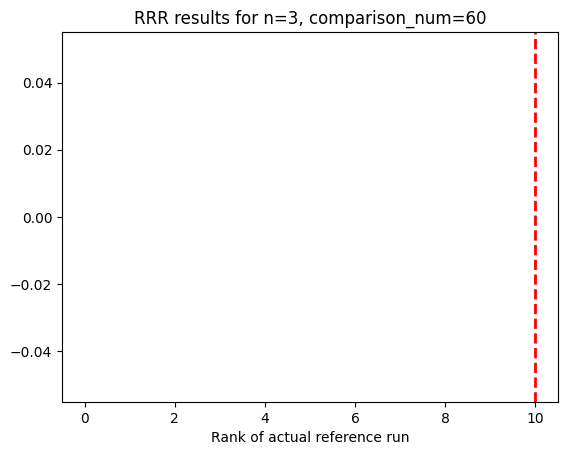

In [38]:
comp_number = 60
n_components = 3

RRranks = tests.test_rank(
    targets_ftrs, 
    candidates_ftrs, 
    comp_number=comp_number, 
    n_components=n_components, 
    print_stats=False, 
    plot=True, 
    dpi=100, 
    return_RRranks=True
)

In [39]:
RRranks

,runs,RRs,ranks


In [273]:
RRranks.sort_values(by=["runs"], inplace=True)
RRranks["runRR_delta"] = RRranks["runs"] - RRranks["RRs"]
RRranks

,runs,RRs,ranks,runRR_delta
123,321219,321067,27,152
197,321221,321067,94,154
29,321230,321067,3,163
44,321231,321067,5,164
28,321232,321067,3,165
...,...,...,...,...
87,325168,323940,13,1228
89,325169,323940,13,1229
116,325170,323940,21,1230
137,325172,323940,41,1232


In [333]:
RRranks["RRs"].unique()

array([321067, 321755, 323940])

(array([ 32.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        128.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  54.]),
 array([321067.  , 321124.46, 321181.92, 321239.38, 321296.84, 321354.3 ,
        321411.76, 321469.22, 321526.68, 321584.14, 321641.6 , 321699.06,
        321756.52, 321813.98, 321871.44, 321928.9 , 321986.36, 322043.82,
        322101.28, 322158.74, 322216.2 , 322273.66, 322331.12, 322388.58,
        322446.04, 322503.5 , 322560.96, 322618.42, 322675.88, 322733.34,
        322790.8 , 322848.26, 322905.72, 322963.18, 323020.64, 323078.1 ,
        323135.56, 323193.02, 323250.48, 323307.94, 323365.4 , 323422.86,
        323480.32, 323537.78, 323595.24, 323652.7 , 323710.16, 323767.62,
        323825.08, 323882.54, 323940.  ]),
 <BarContainer object o

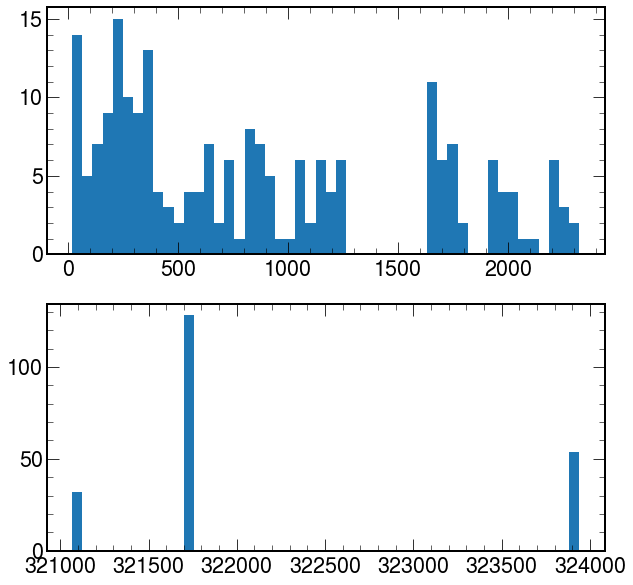

In [327]:
# Making histograms of difference in run number and actual RRs used
fig, axs = plt.subplots(2)
axs[0].hist(RRranks["runRR_delta"], bins=50)
axs[1].hist(RRranks["RRs"], bins=50)


In [250]:
# Looking at those RR which scored badly
RRranks_GE60 = RRranks[RRranks["ranks"] >= 60]
RRranks_GE60

,runs,RRs,ranks
197,321221,321067,94
200,321310,321067,96
154,321311,321067,67
201,321312,321067,100
204,321313,321067,104
...,...,...,...
182,324729,323940,81
157,324769,323940,69
183,324772,323940,82
165,324846,323940,73


In [329]:
RRranks_max = RRranks[RRranks["ranks"] == RRranks["ranks"].max()]
RRranks_max

,runs,RRs,ranks,runRR_delta
211,322483,321755,112,728
212,322485,321755,112,730
213,322487,321755,112,732


In [330]:
pd.DataFrame(targets_wRR.loc[RRranks_max.iloc[0]["runs"]]).T

,run_number,b_field,init_lumi,energy,end_lumi,hlt_physics_rate,l1_rate,fill_number,last_lumisection_number,duration,RR_used
322483,322483.0,3.801,1.392686,6499.0,1.385027,1.201,84.985,7139.0,8.0,96.0,321755.0


In [331]:
pd.DataFrame(candidates_df.loc[RRranks_max.iloc[0]["RRs"]]).T

,run_number,b_field,init_lumi,energy,end_lumi,hlt_physics_rate,l1_rate,fill_number,last_lumisection_number,duration,RR_used
321755,321755.0,3.801,1.725508,6499.0,1.160929,1595.931,68392.98,7083.0,729.0,16852.0,318953.0


In [177]:
# Testing on a wide range of possible value combinations
comp_number_range = np.arange(20, 130, 20)
n_components_range = np.arange(1, len(ftrs_lst) - 4)

Mean rank of actual RR: 8.36046511627907
Median rank of actual RR: 8.0
Top-k accuracy (k=10): 0.6085271317829457
Mean reciprocal rank: 0.1630425992889093


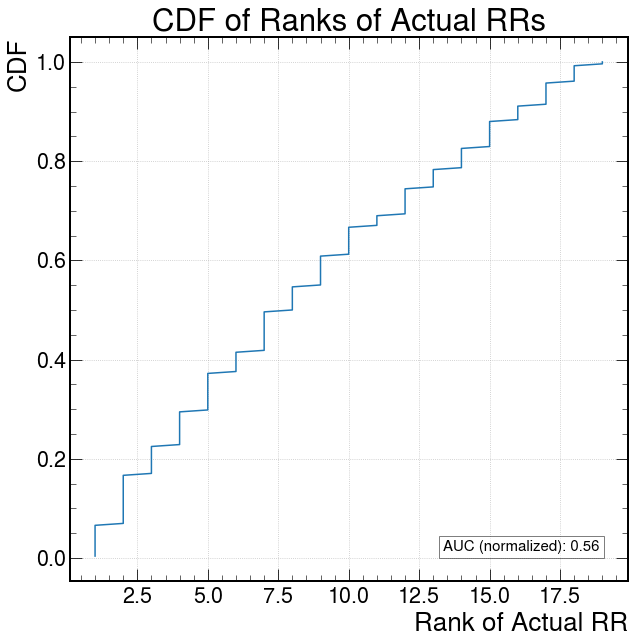

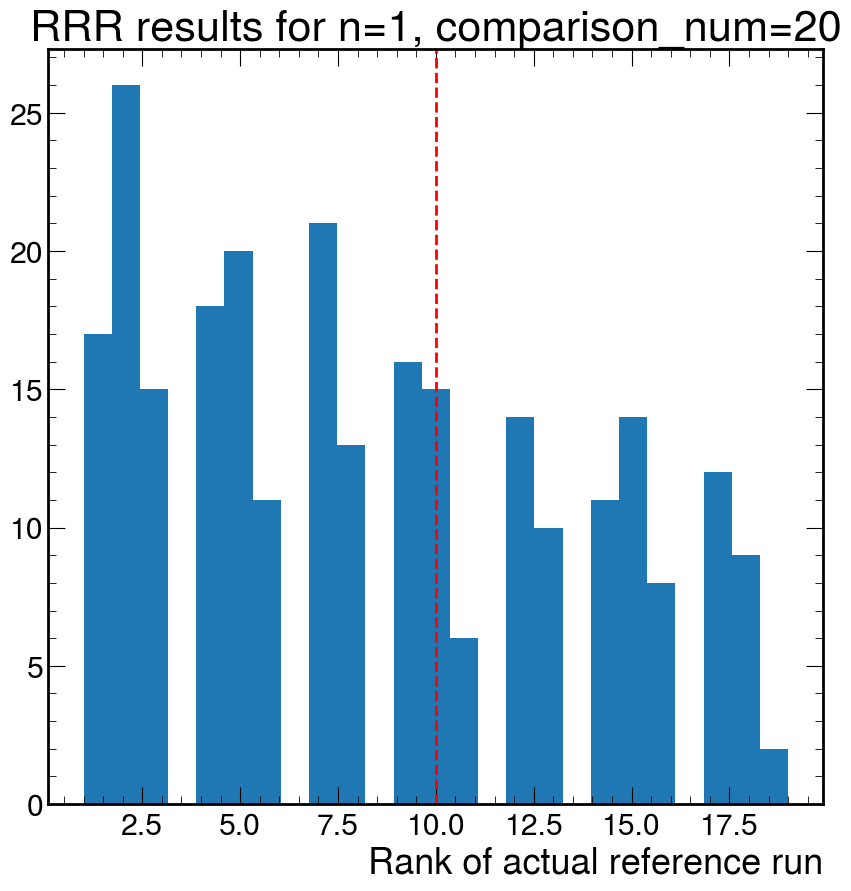

Mean rank of actual RR: 9.468992248062015
Median rank of actual RR: 10.0
Top-k accuracy (k=10): 0.4689922480620155
Mean reciprocal rank: 0.14215290956327026


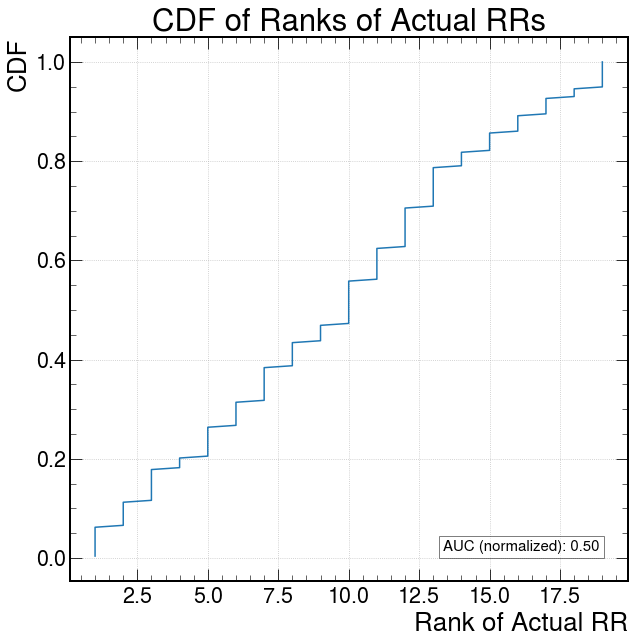

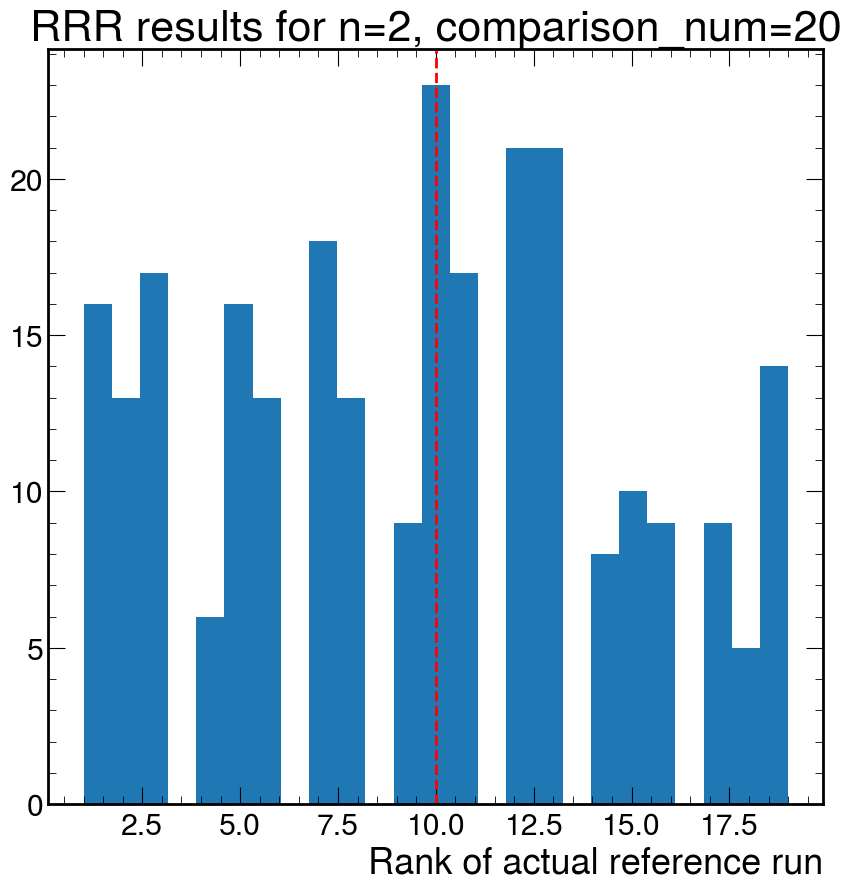

Mean rank of actual RR: 9.511627906976743
Median rank of actual RR: 10.0
Top-k accuracy (k=10): 0.47674418604651164
Mean reciprocal rank: 0.14583438901919354


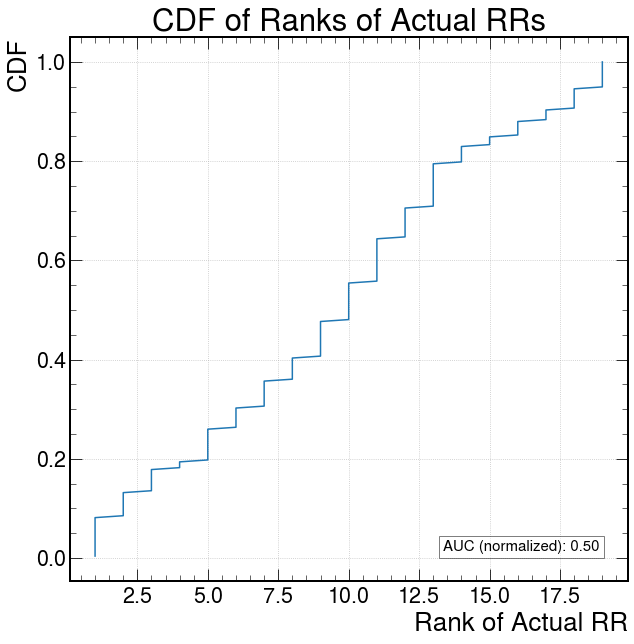

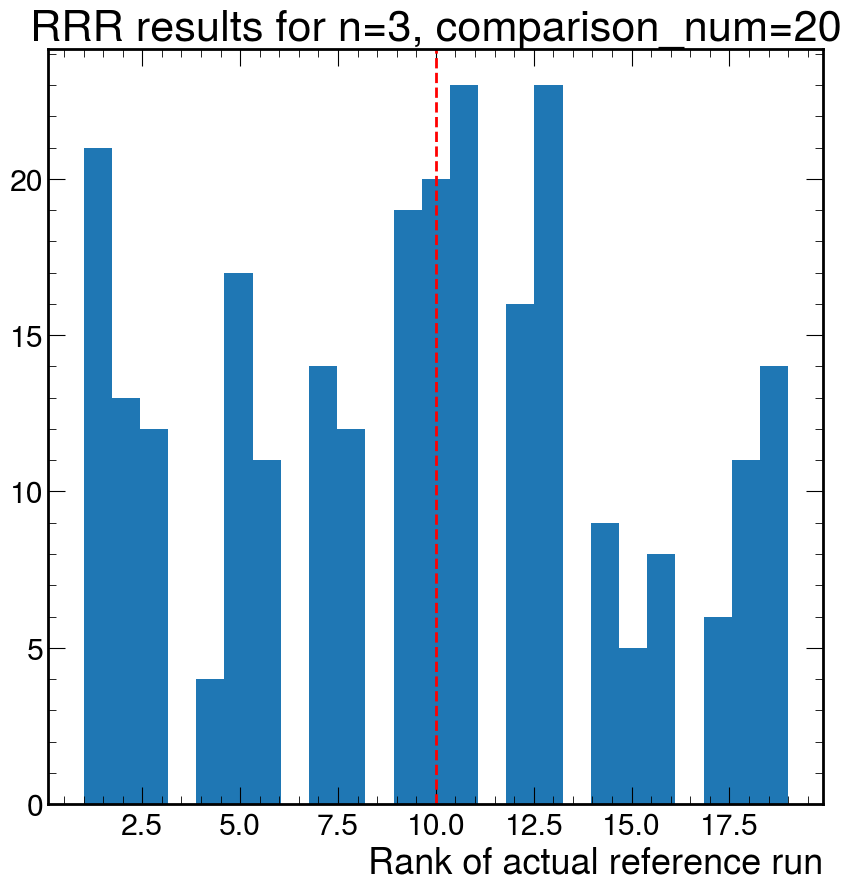

Mean rank of actual RR: 9.643410852713178
Median rank of actual RR: 10.0
Top-k accuracy (k=10): 0.46124031007751937
Mean reciprocal rank: 0.14665879824143555


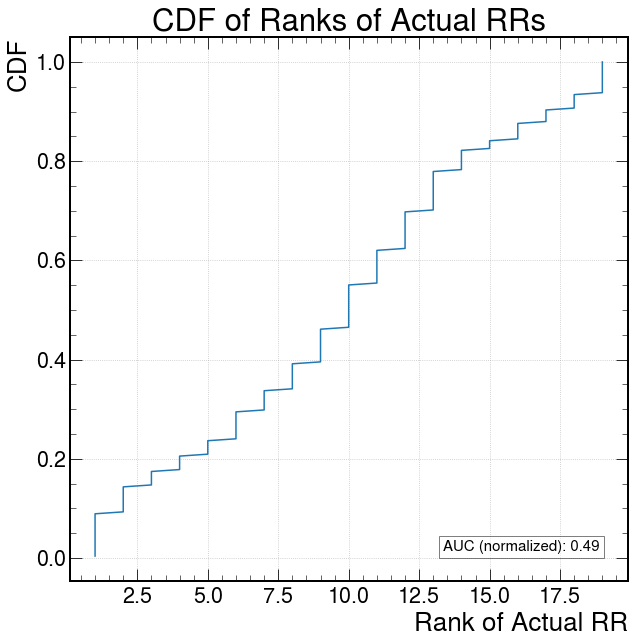

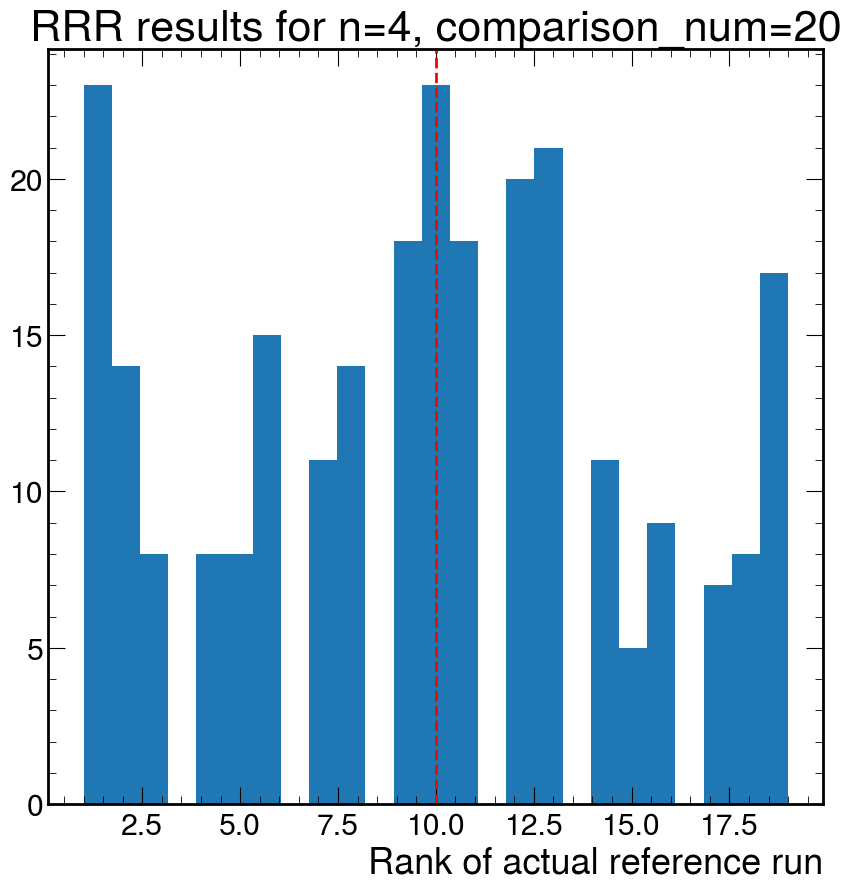

Mean rank of actual RR: 9.806201550387597
Median rank of actual RR: 10.0
Top-k accuracy (k=10): 0.4496124031007752
Mean reciprocal rank: 0.1393756833961312


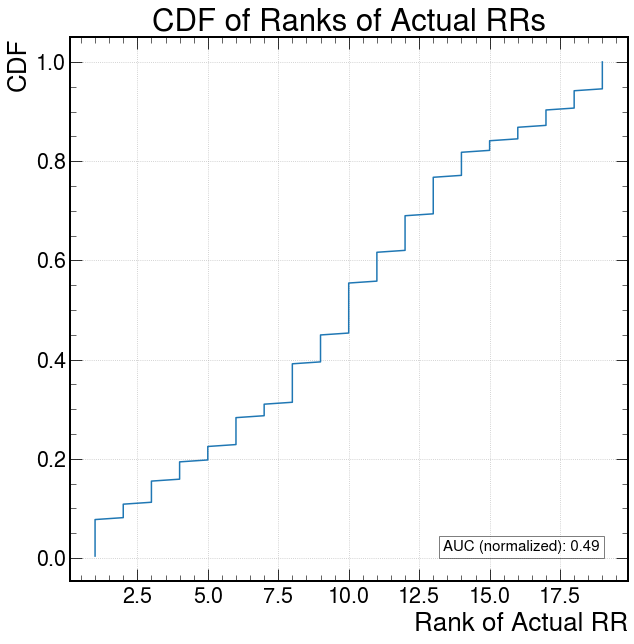

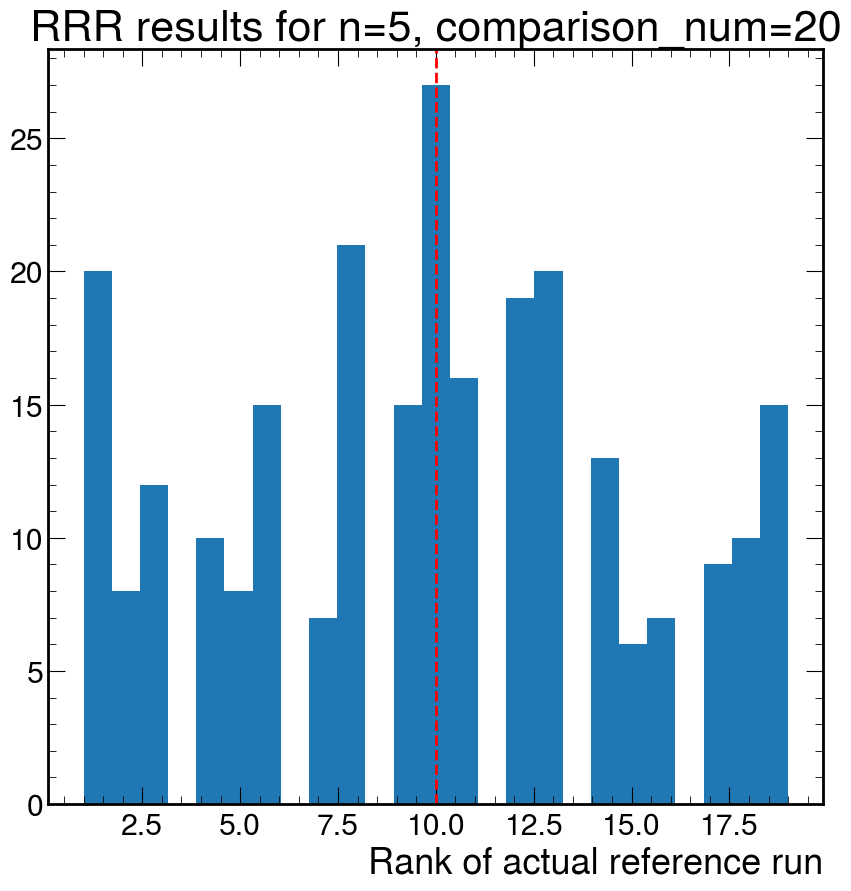

Mean rank of actual RR: 9.7984496124031
Median rank of actual RR: 10.0
Top-k accuracy (k=10): 0.4496124031007752
Mean reciprocal rank: 0.14071789738369406


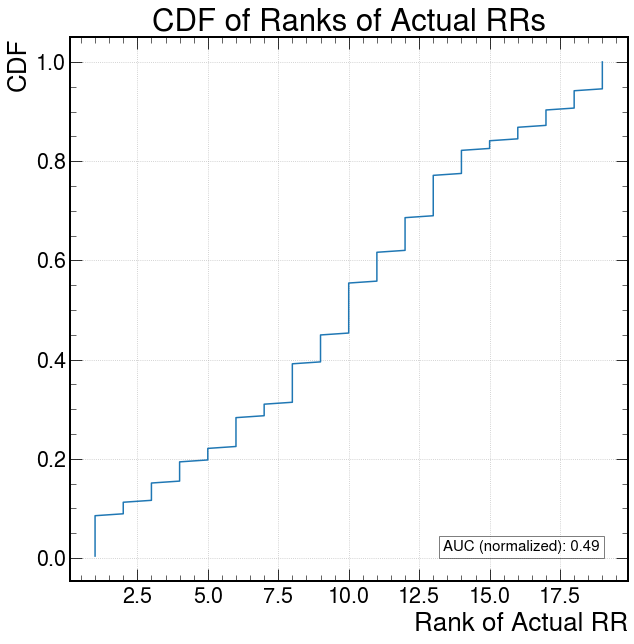

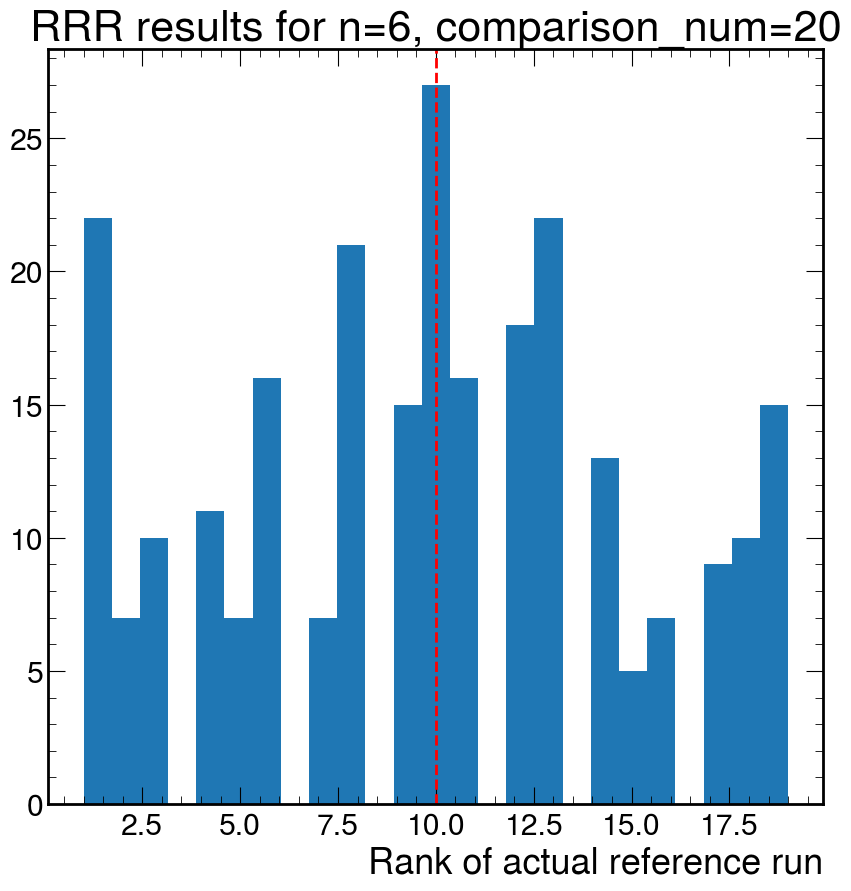

Mean rank of actual RR: 16.6010101010101
Median rank of actual RR: 15.0
Top-k accuracy (k=10): 0.29545454545454547
Mean reciprocal rank: 0.1012189787830068


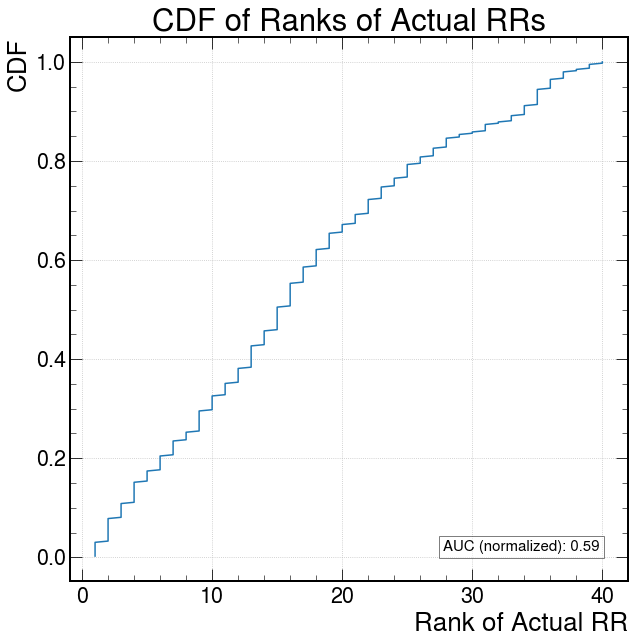

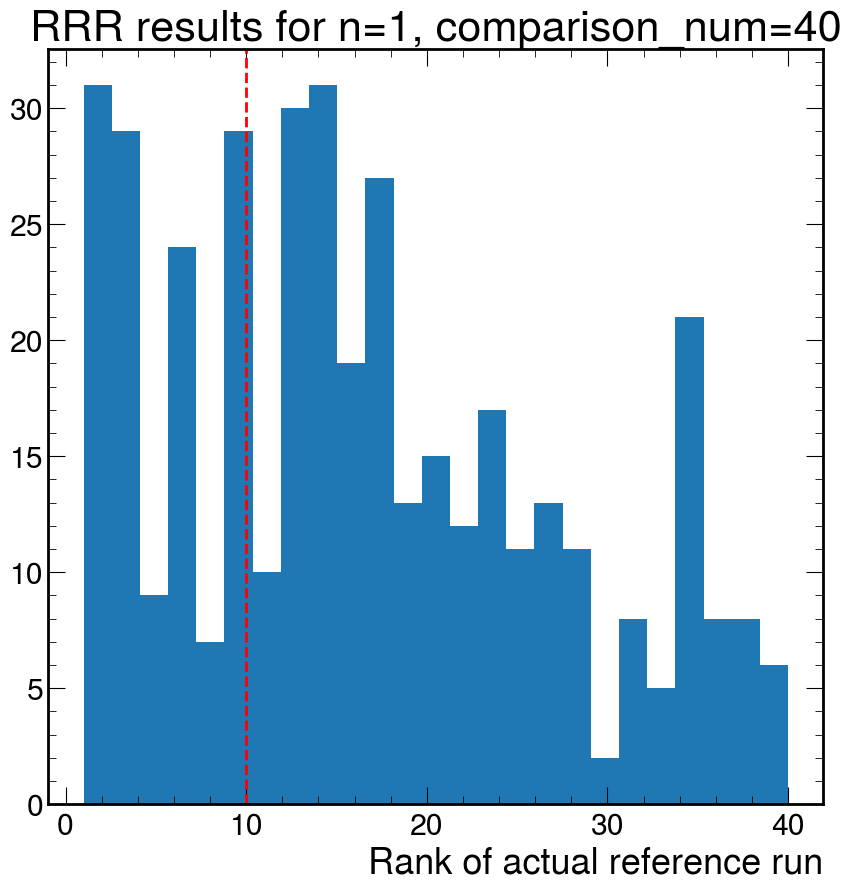

Mean rank of actual RR: 17.353535353535353
Median rank of actual RR: 16.0
Top-k accuracy (k=10): 0.255050505050505
Mean reciprocal rank: 0.09554295200665389


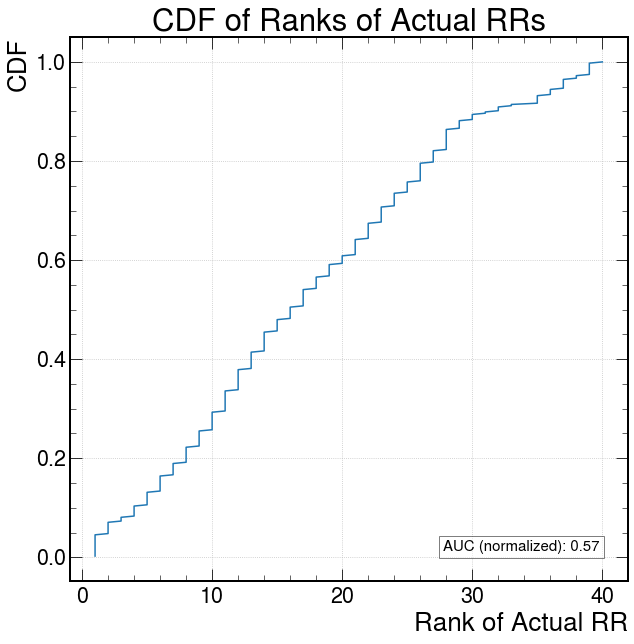

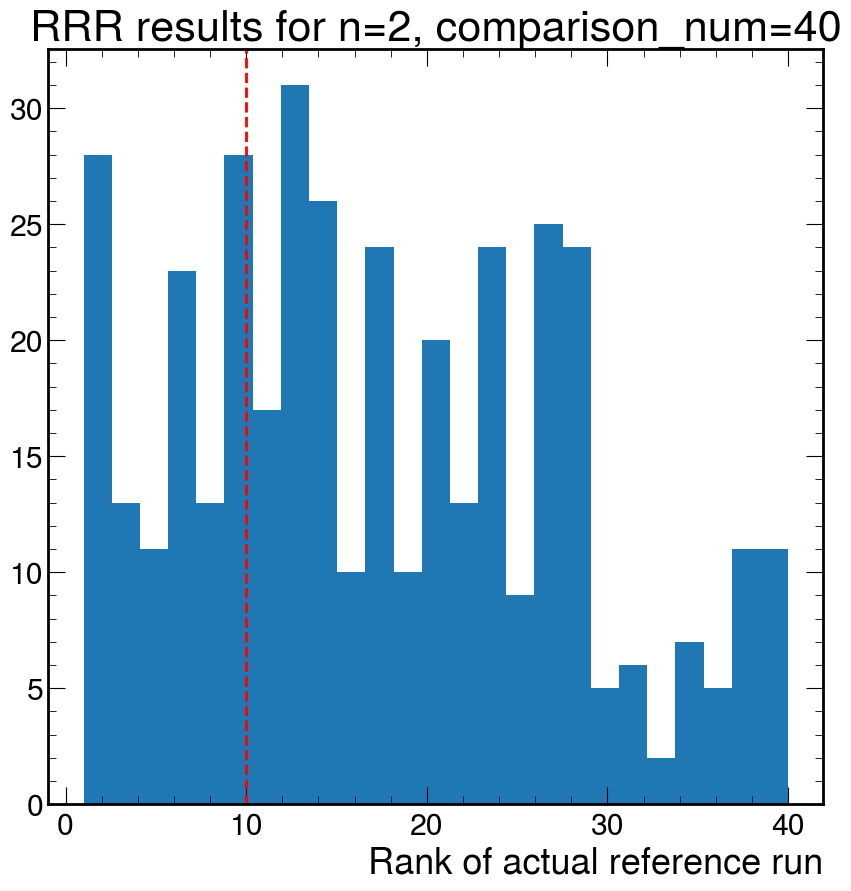

Mean rank of actual RR: 17.47979797979798
Median rank of actual RR: 17.0
Top-k accuracy (k=10): 0.25757575757575757
Mean reciprocal rank: 0.09670864131850954


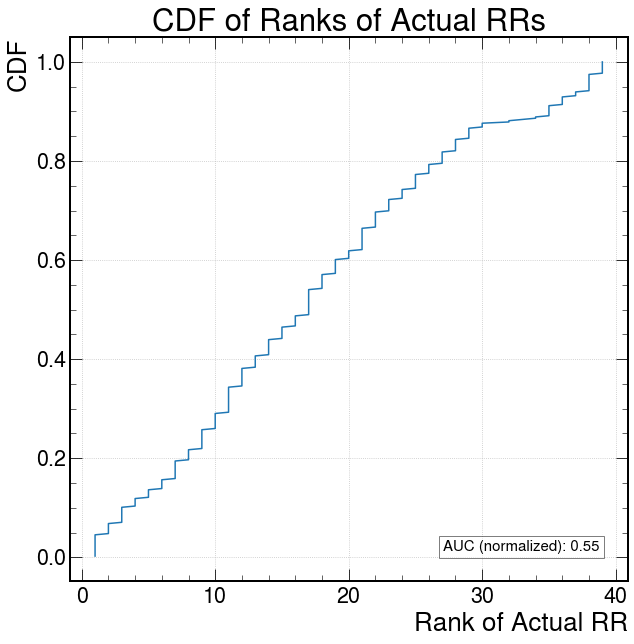

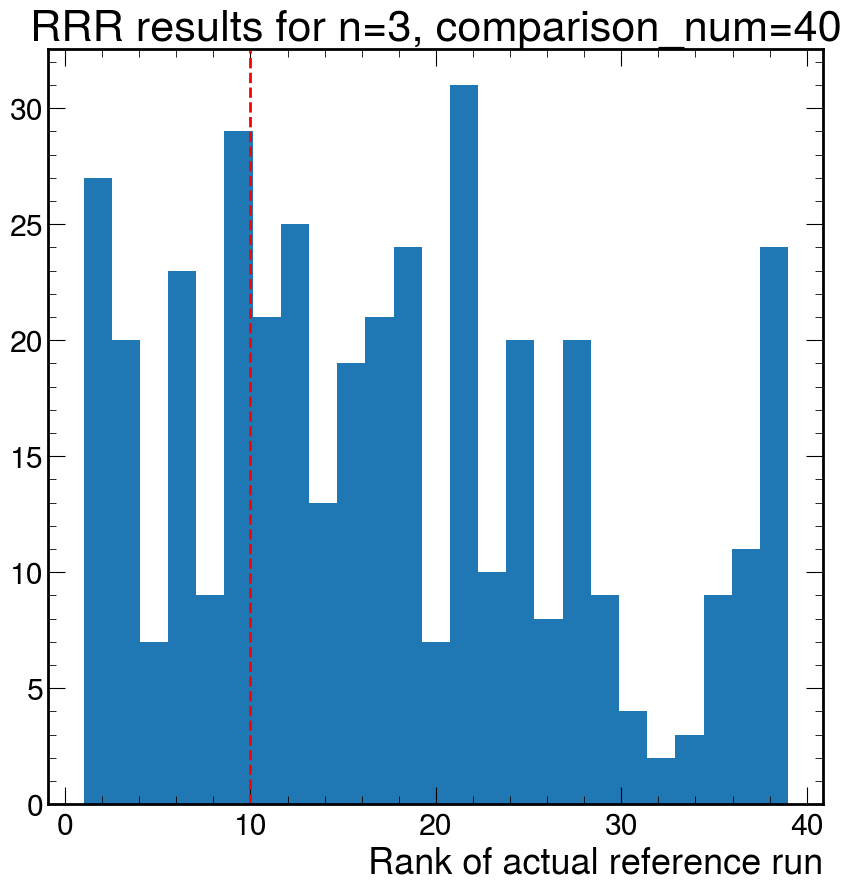

Mean rank of actual RR: 17.803030303030305
Median rank of actual RR: 17.0
Top-k accuracy (k=10): 0.26262626262626265
Mean reciprocal rank: 0.09598379240061826


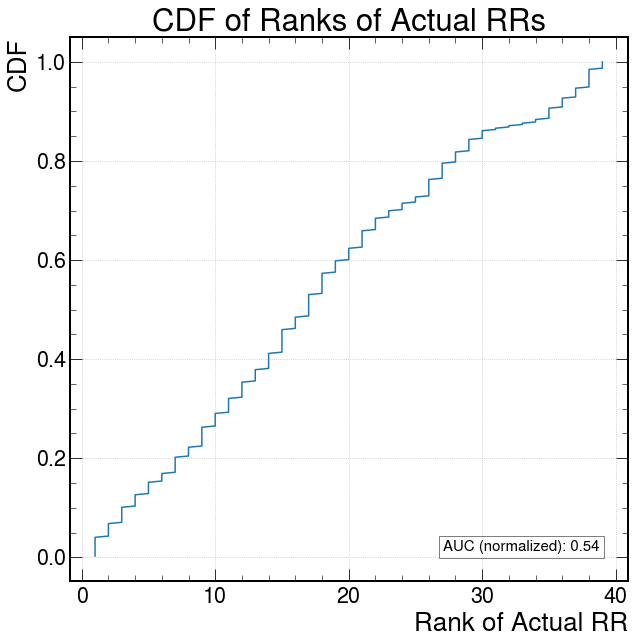

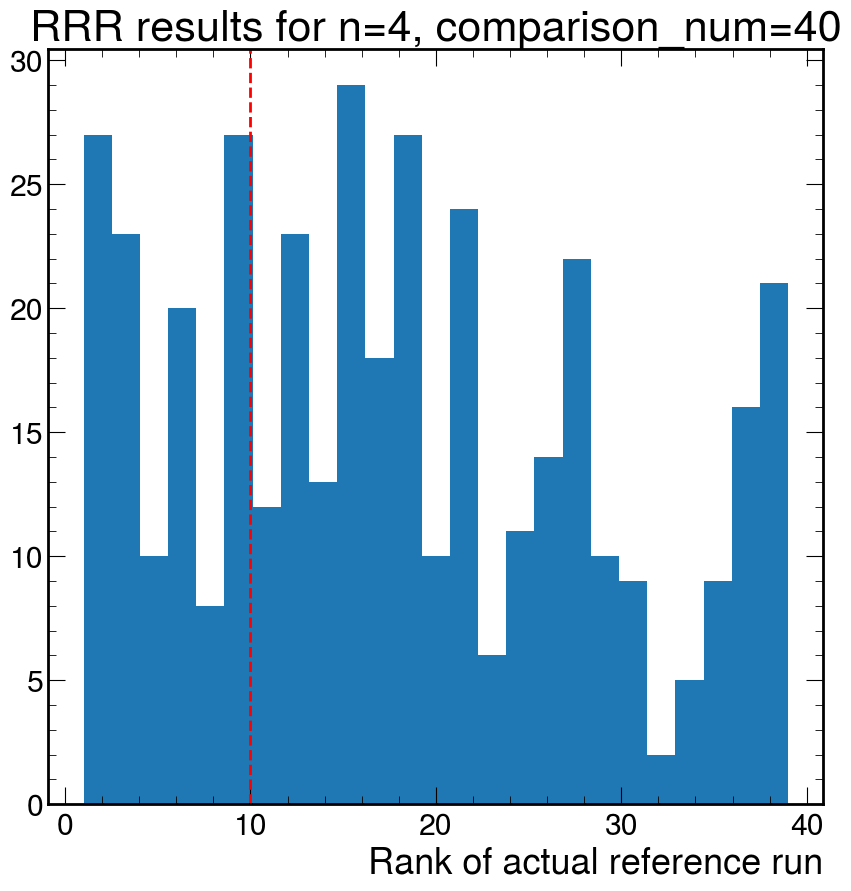

Mean rank of actual RR: 18.151515151515152
Median rank of actual RR: 17.0
Top-k accuracy (k=10): 0.2474747474747475
Mean reciprocal rank: 0.09557813769814644


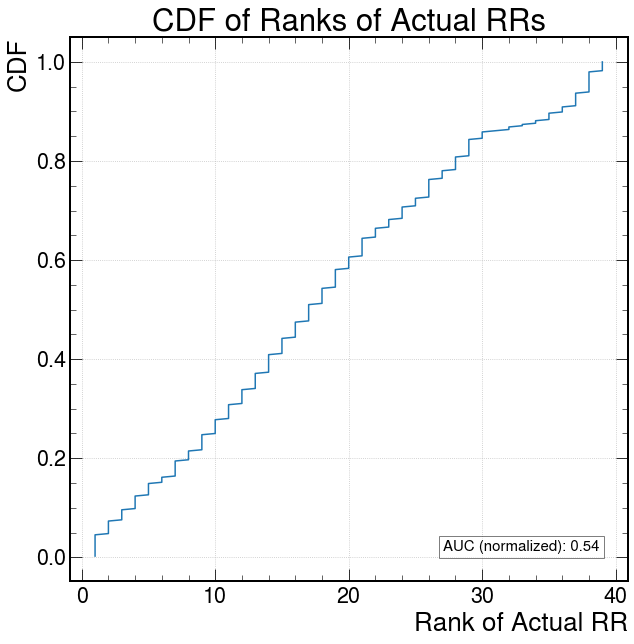

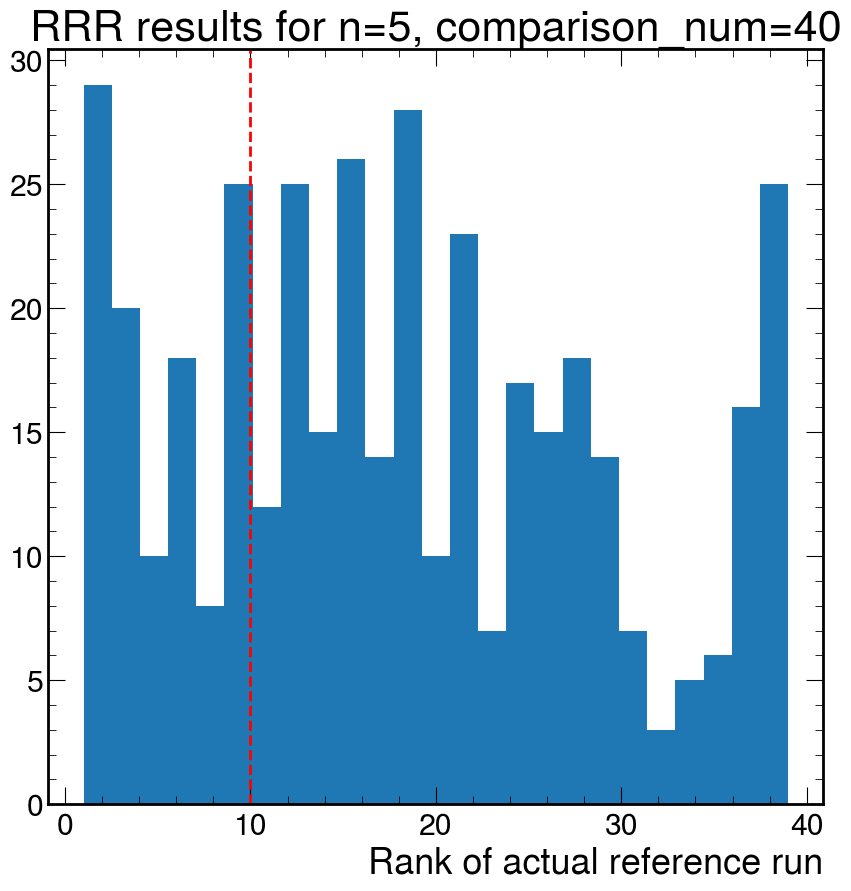

Mean rank of actual RR: 18.358585858585858
Median rank of actual RR: 17.0
Top-k accuracy (k=10): 0.23484848484848486
Mean reciprocal rank: 0.09054272046278587


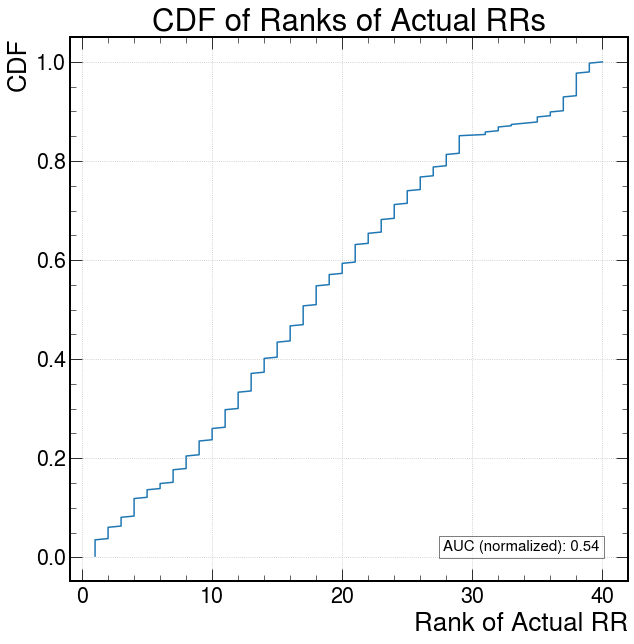

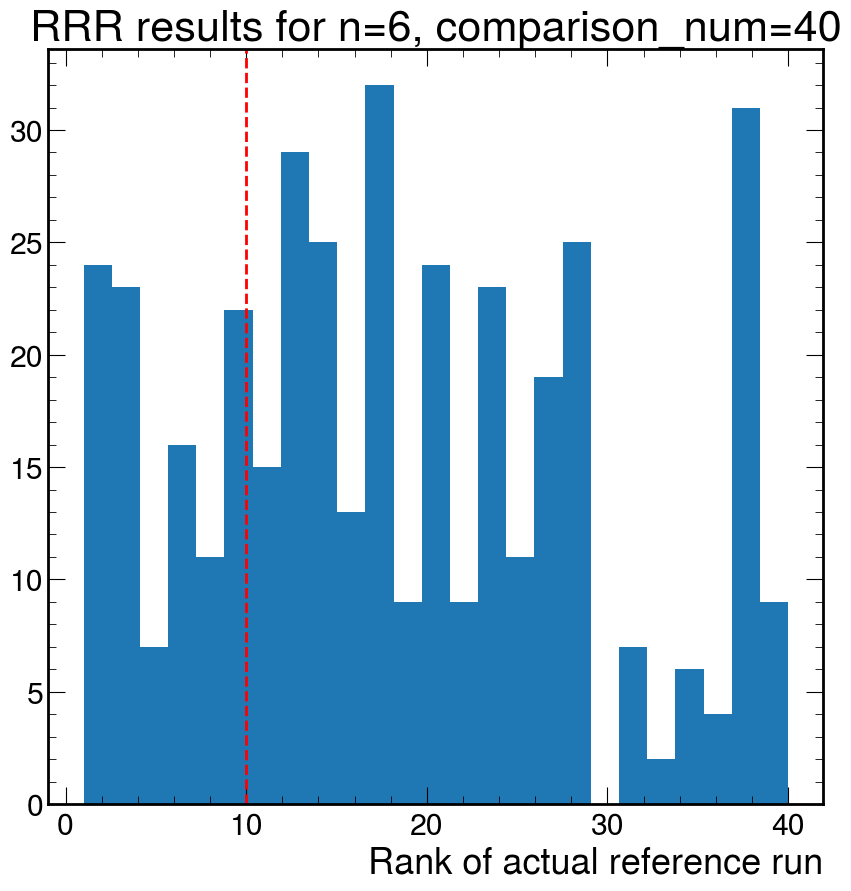

Mean rank of actual RR: 23.36
Median rank of actual RR: 22.0
Top-k accuracy (k=10): 0.23466666666666666
Mean reciprocal rank: 0.07909610785769687


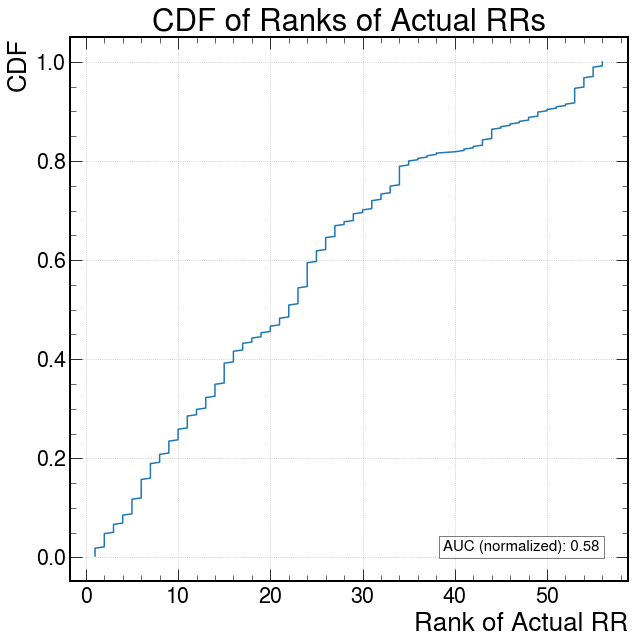

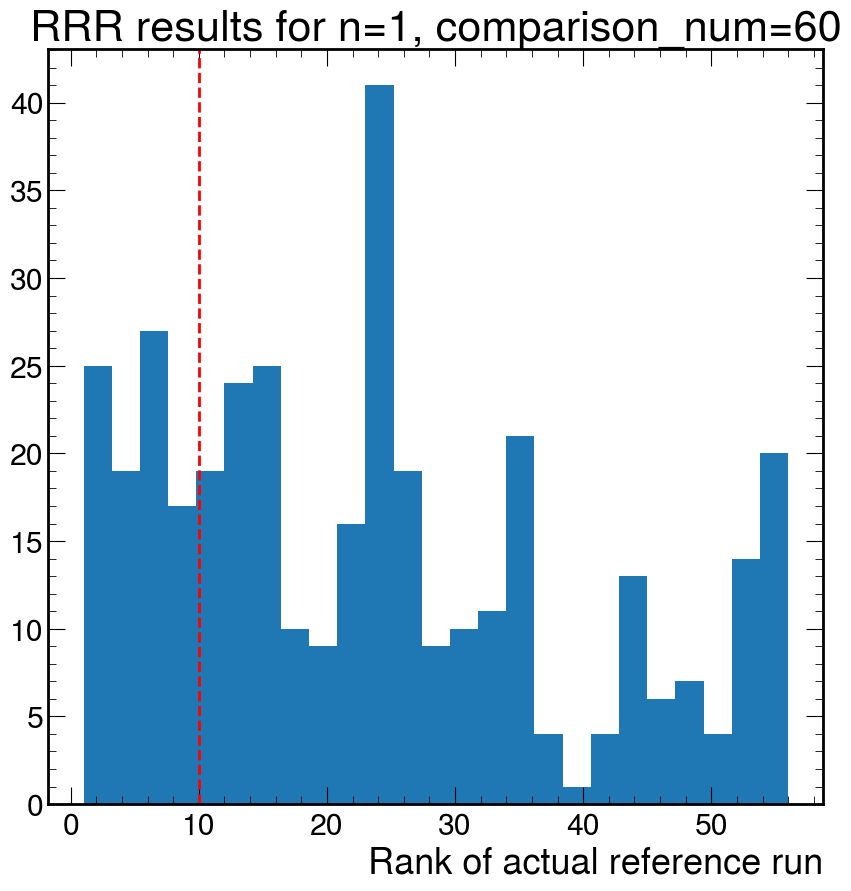

Mean rank of actual RR: 21.882666666666665
Median rank of actual RR: 19.0
Top-k accuracy (k=10): 0.19733333333333333
Mean reciprocal rank: 0.08048390024199248


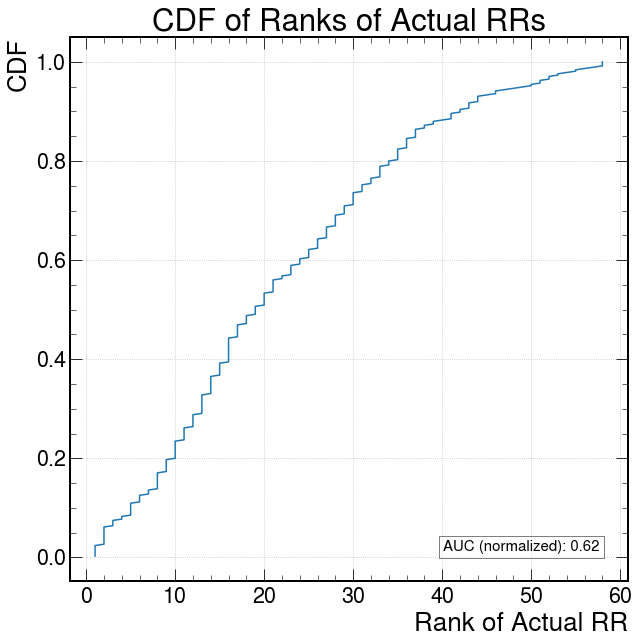

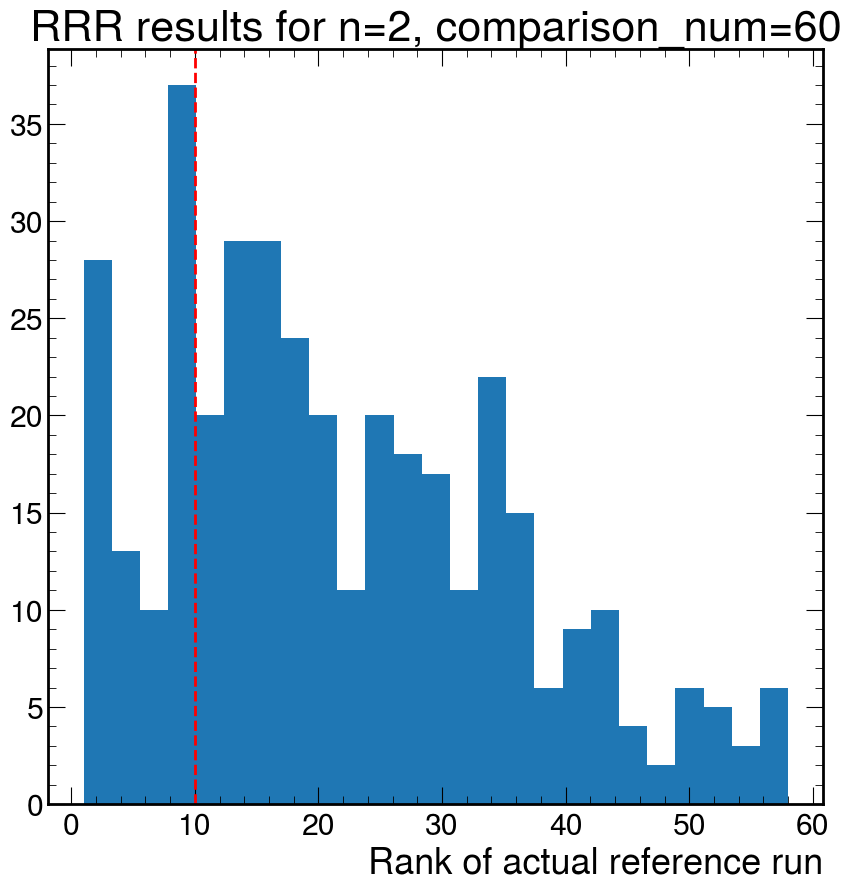

Mean rank of actual RR: 22.8
Median rank of actual RR: 20.0
Top-k accuracy (k=10): 0.19466666666666665
Mean reciprocal rank: 0.0727155794580238


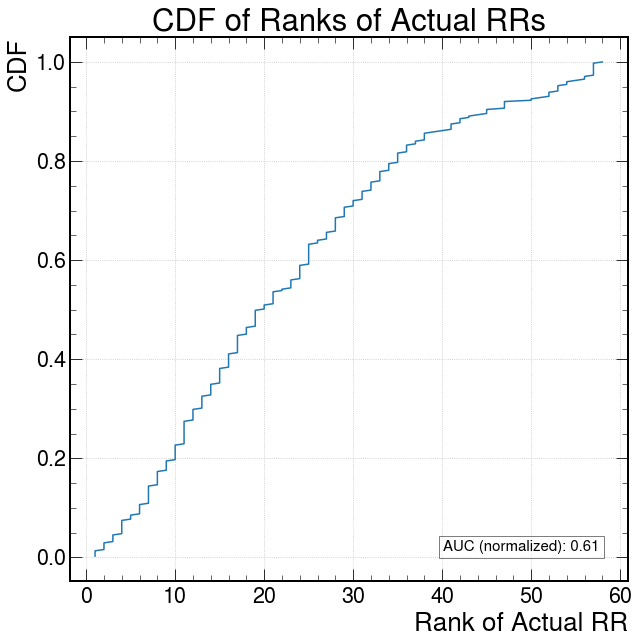

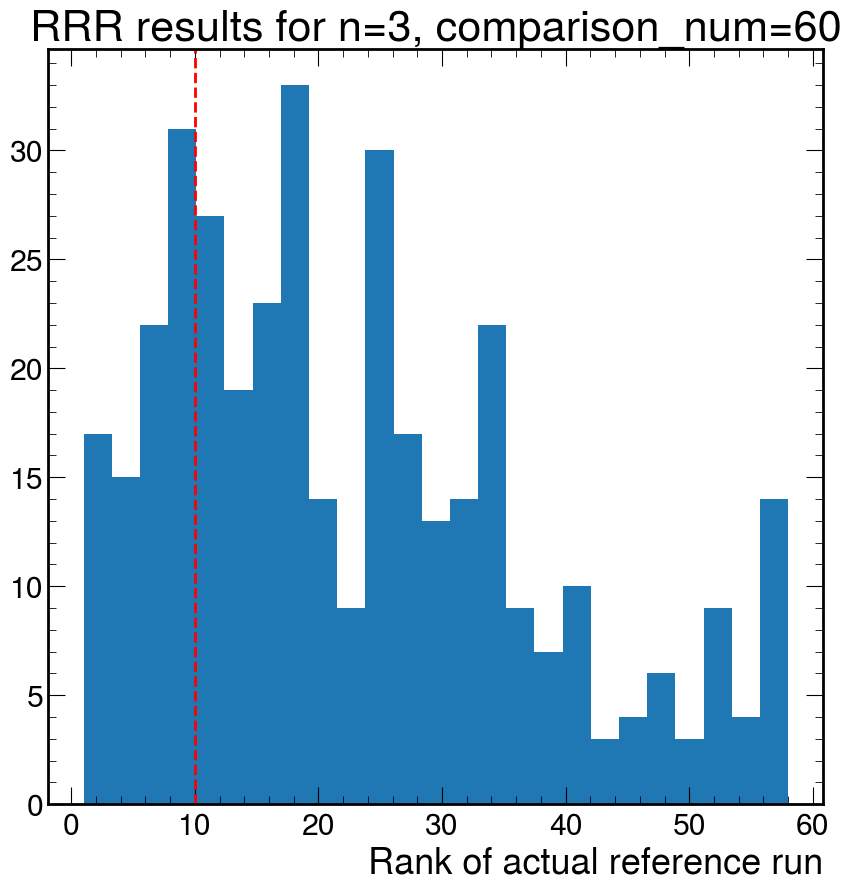

Mean rank of actual RR: 22.378666666666668
Median rank of actual RR: 20.0
Top-k accuracy (k=10): 0.192
Mean reciprocal rank: 0.07612870844435489


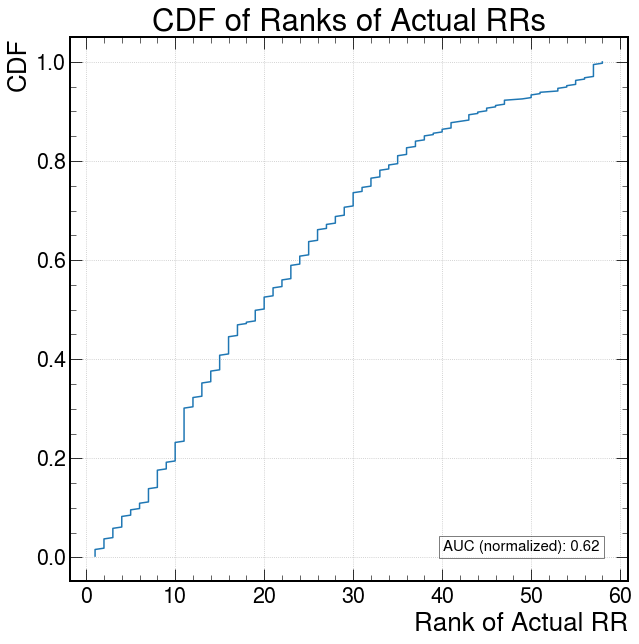

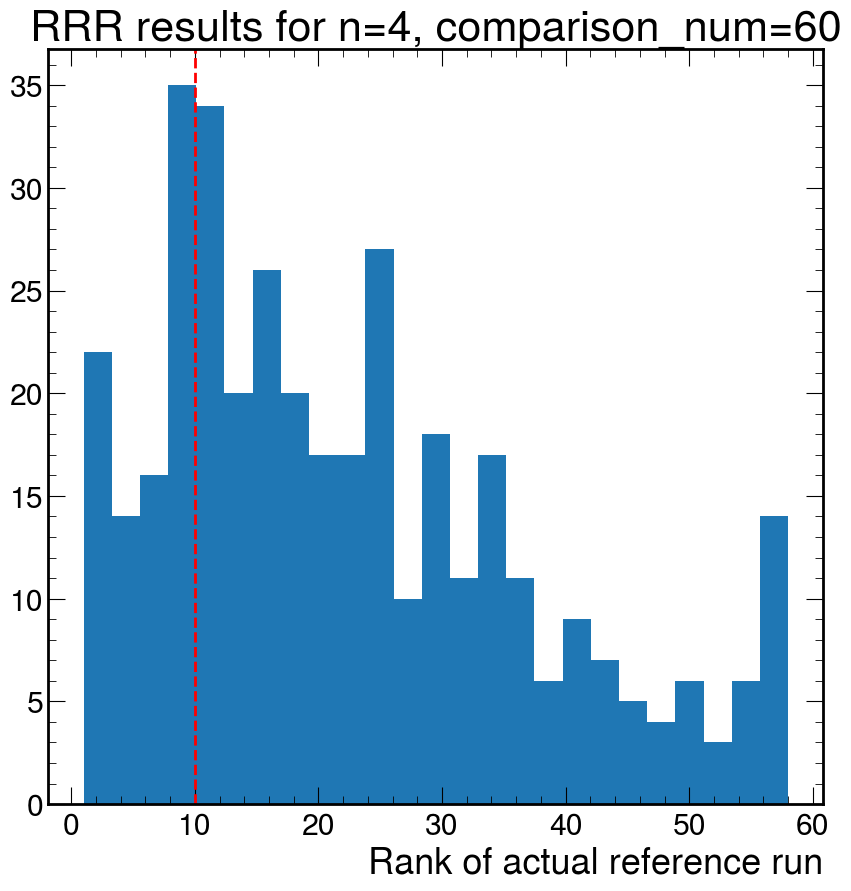

Mean rank of actual RR: 22.458666666666666
Median rank of actual RR: 20.0
Top-k accuracy (k=10): 0.18933333333333333
Mean reciprocal rank: 0.0743061498310668


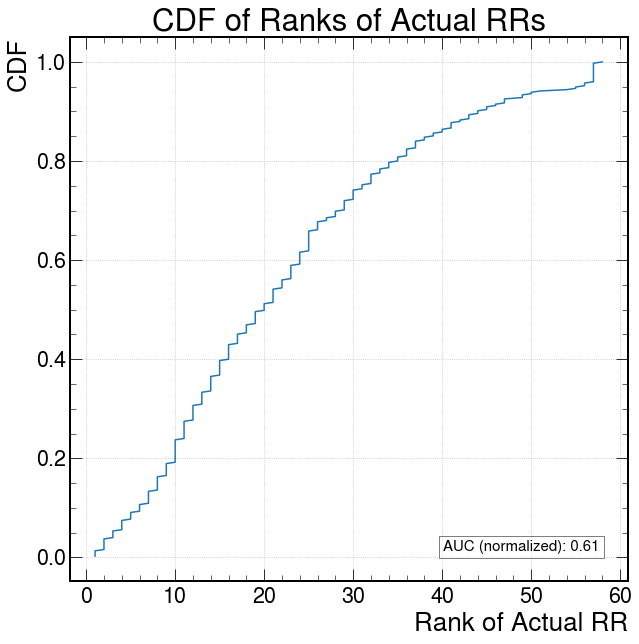

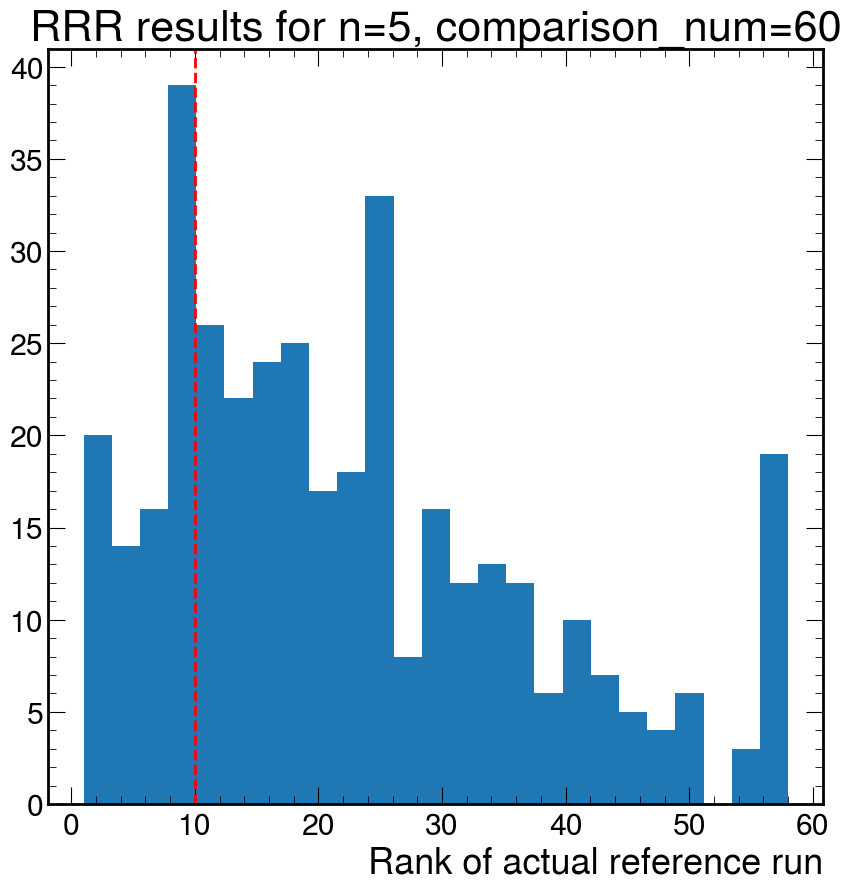

Mean rank of actual RR: 22.624
Median rank of actual RR: 20.0
Top-k accuracy (k=10): 0.2
Mean reciprocal rank: 0.07768351053670376


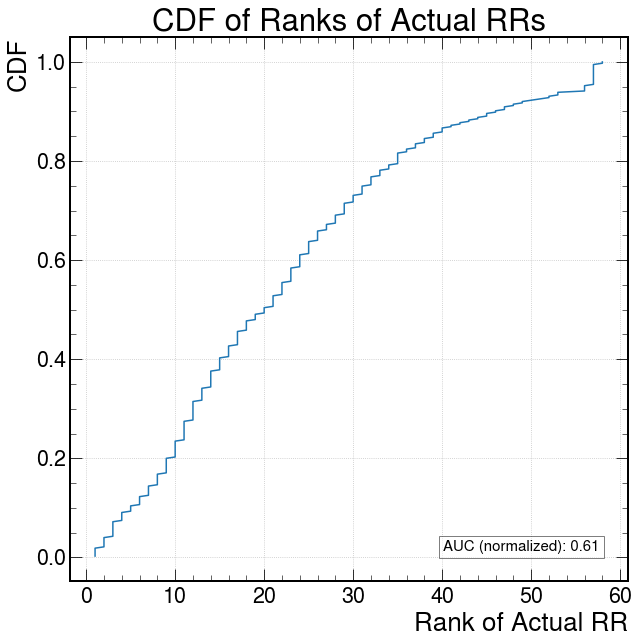

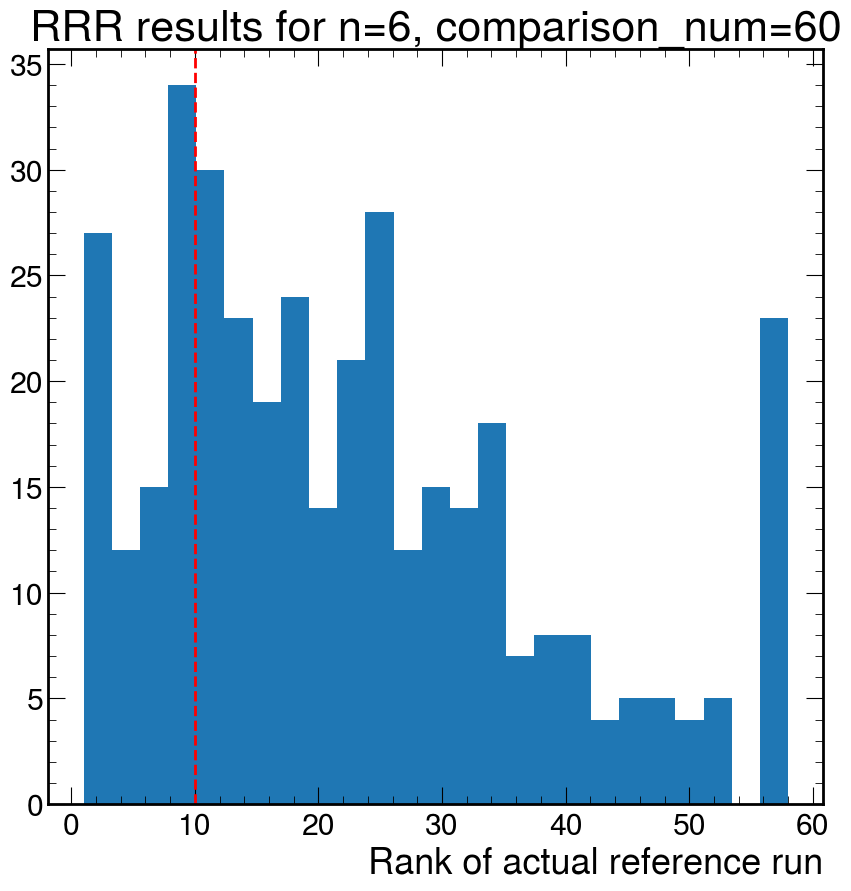

Mean rank of actual RR: 31.88719512195122
Median rank of actual RR: 29.5
Top-k accuracy (k=10): 0.21951219512195122
Mean reciprocal rank: 0.07395761536822773


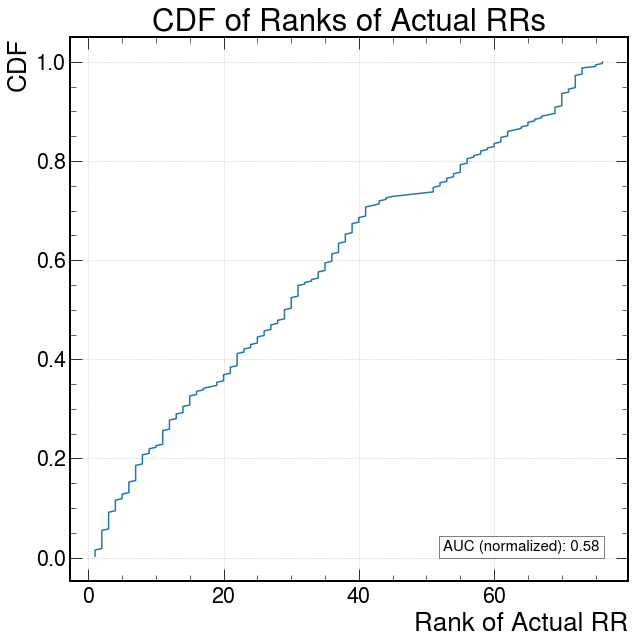

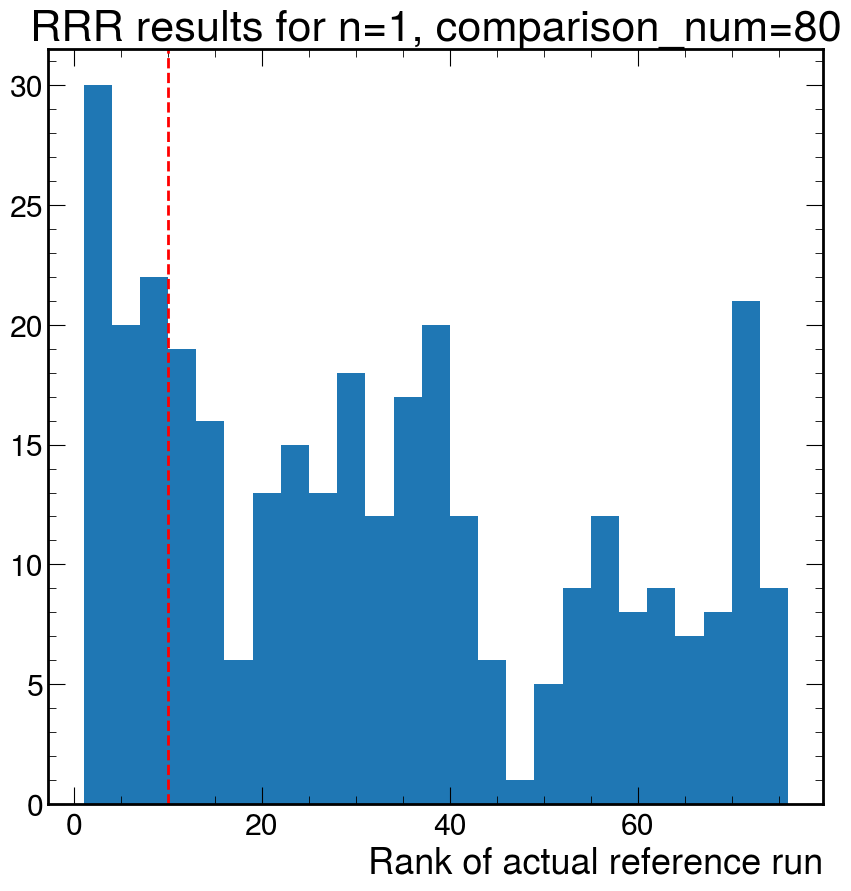

Mean rank of actual RR: 25.734756097560975
Median rank of actual RR: 24.0
Top-k accuracy (k=10): 0.21036585365853658
Mean reciprocal rank: 0.07968791912084211


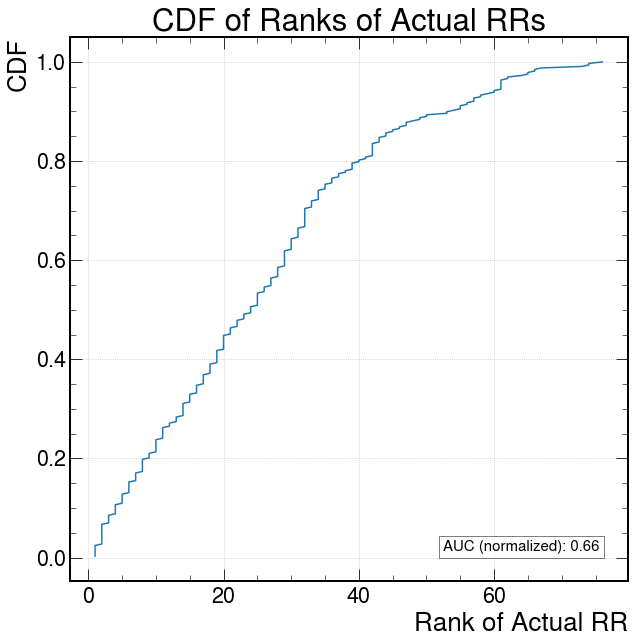

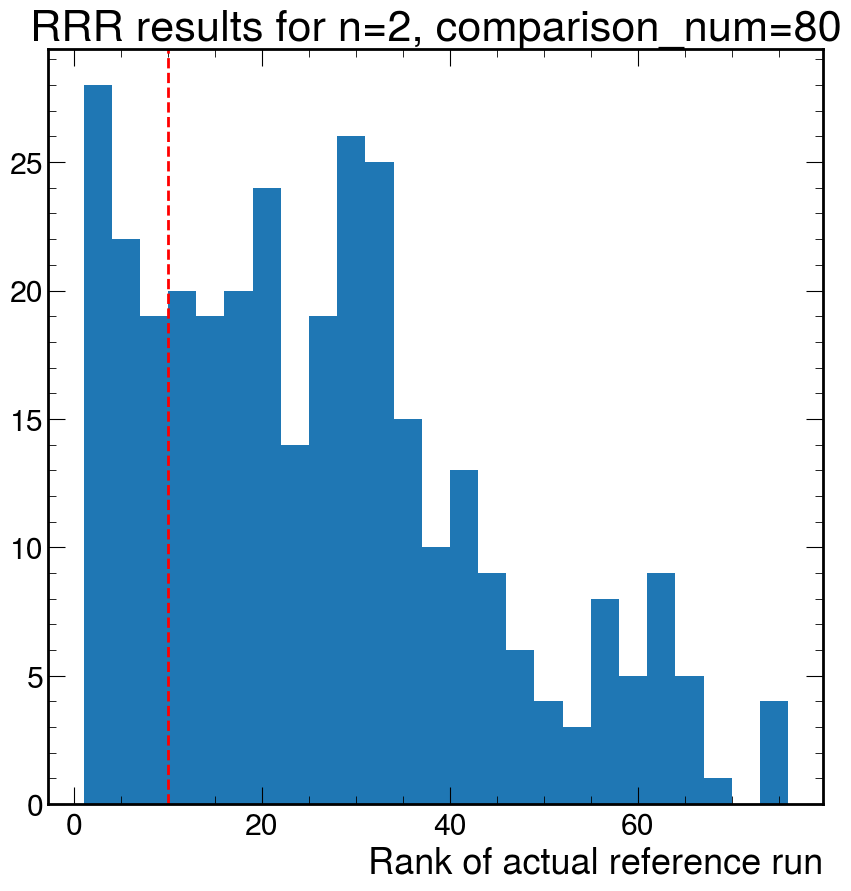

Mean rank of actual RR: 27.625
Median rank of actual RR: 24.0
Top-k accuracy (k=10): 0.2073170731707317
Mean reciprocal rank: 0.08210999951732305


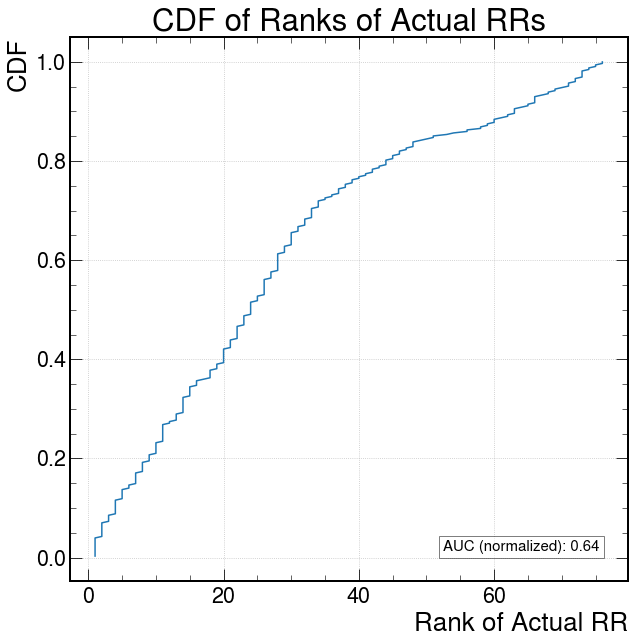

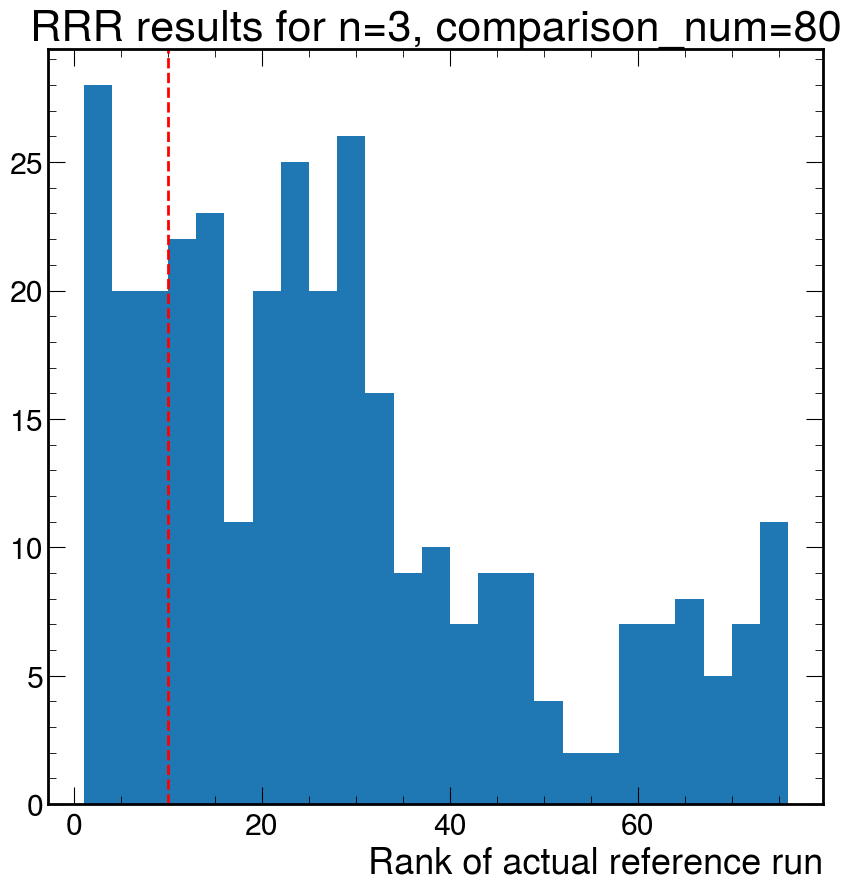

Mean rank of actual RR: 27.85670731707317
Median rank of actual RR: 24.0
Top-k accuracy (k=10): 0.17682926829268292
Mean reciprocal rank: 0.06769642702422633


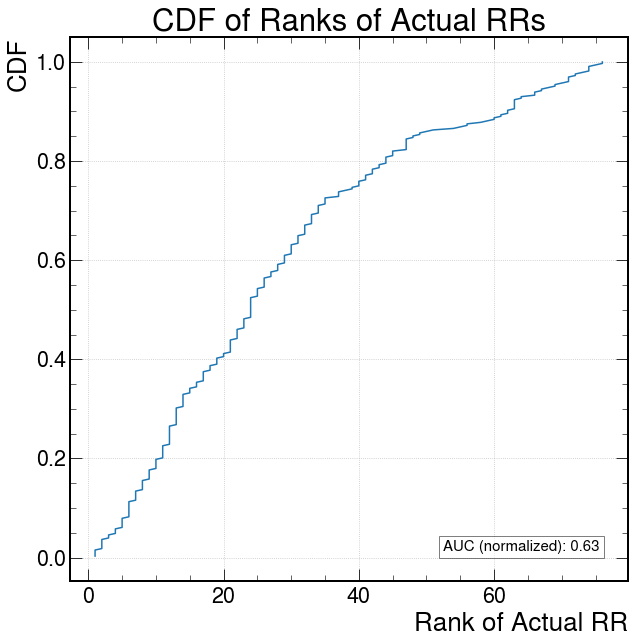

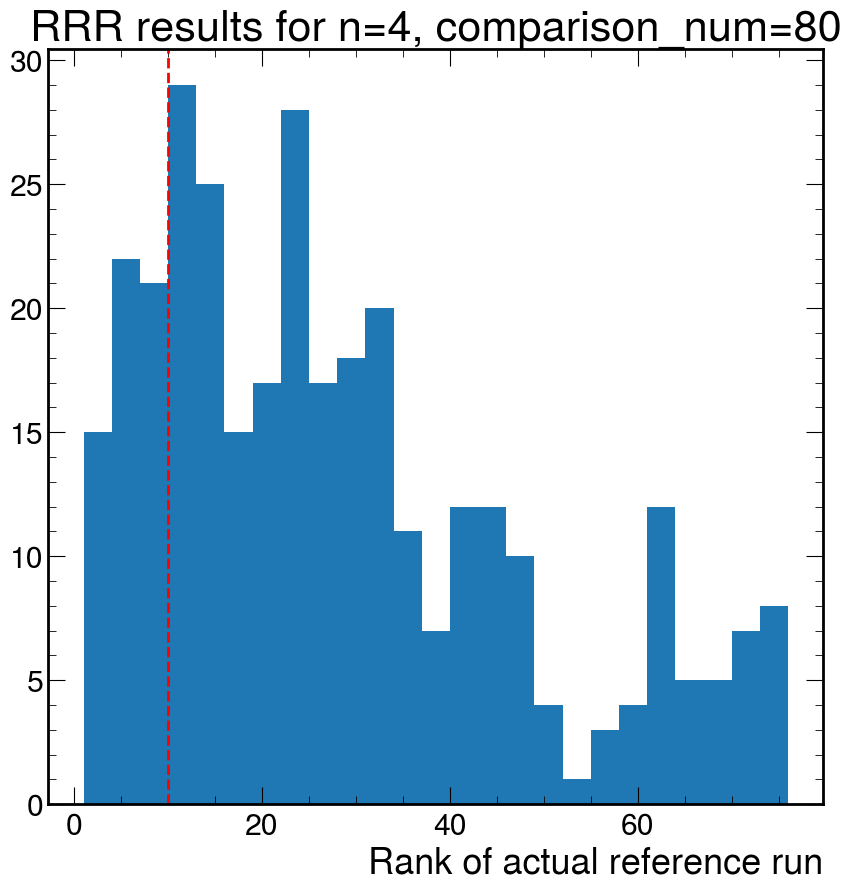

Mean rank of actual RR: 27.783536585365855
Median rank of actual RR: 24.0
Top-k accuracy (k=10): 0.1676829268292683
Mean reciprocal rank: 0.06652892816665554


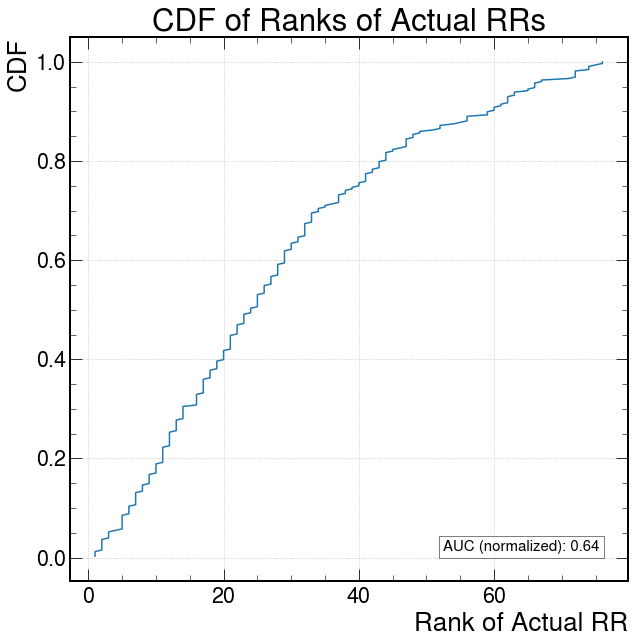

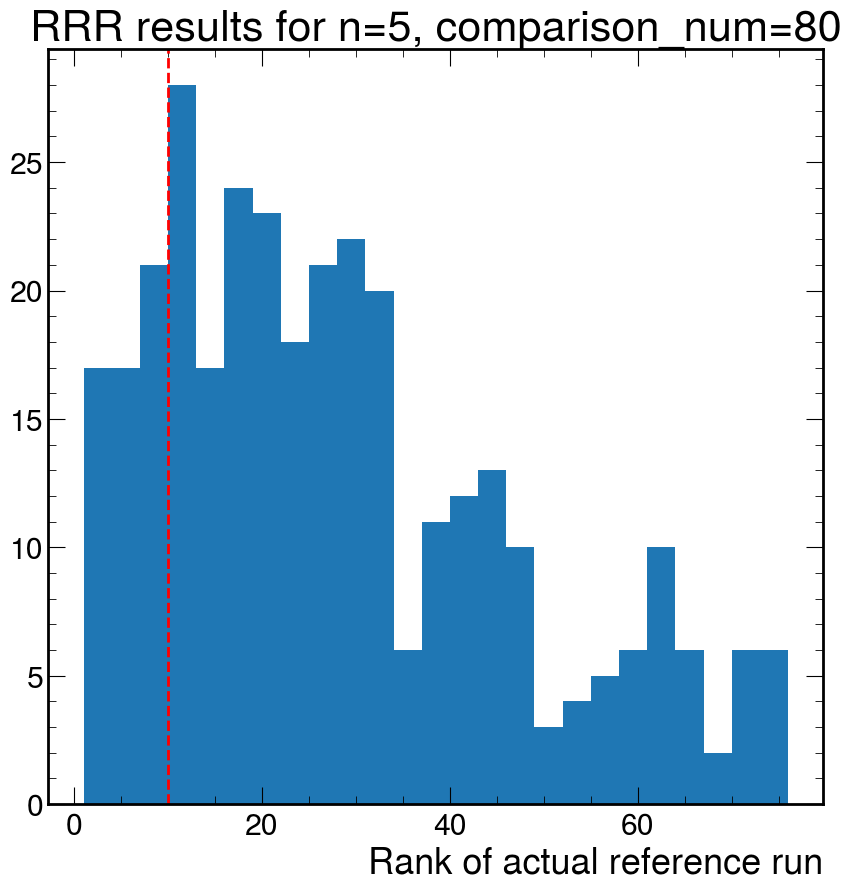

Mean rank of actual RR: 27.152439024390244
Median rank of actual RR: 23.0
Top-k accuracy (k=10): 0.16158536585365854
Mean reciprocal rank: 0.06959466325719482


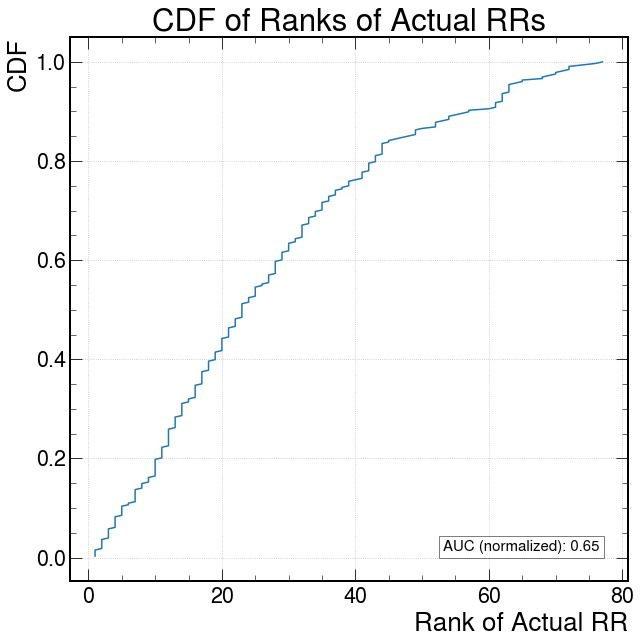

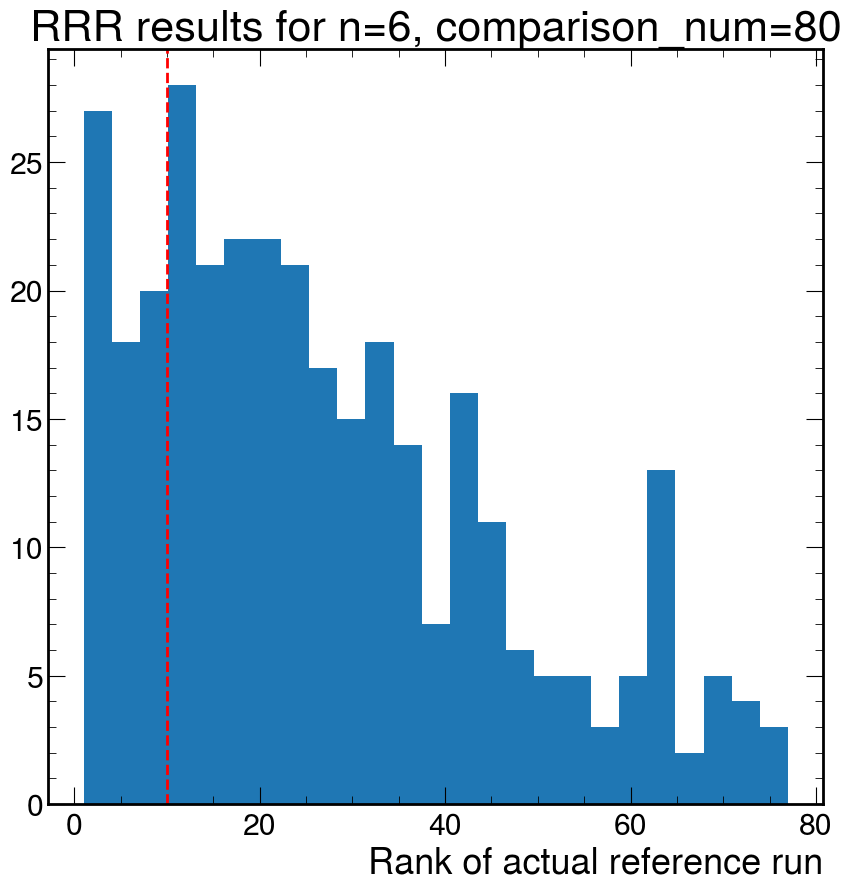

Mean rank of actual RR: 41.408088235294116
Median rank of actual RR: 36.0
Top-k accuracy (k=10): 0.20955882352941177
Mean reciprocal rank: 0.07138299354312228


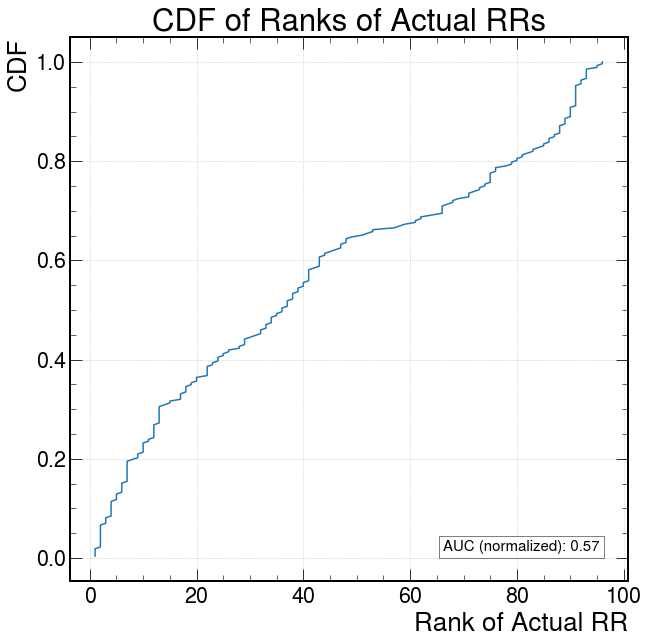

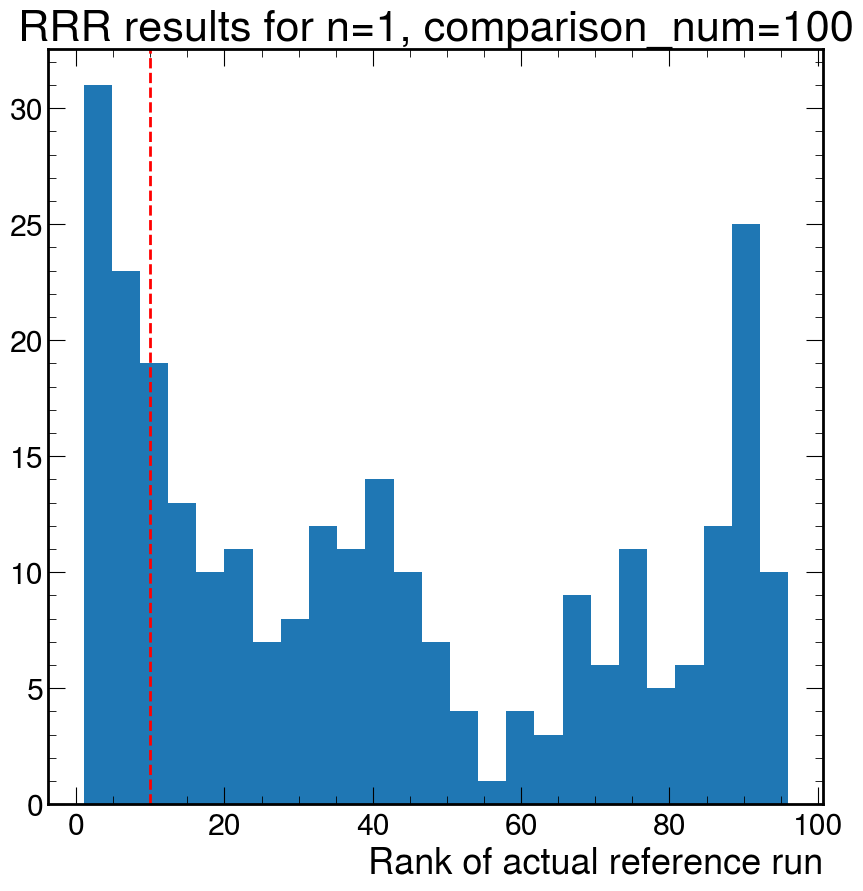

Mean rank of actual RR: 29.9375
Median rank of actual RR: 21.5
Top-k accuracy (k=10): 0.25
Mean reciprocal rank: 0.08193955042586896


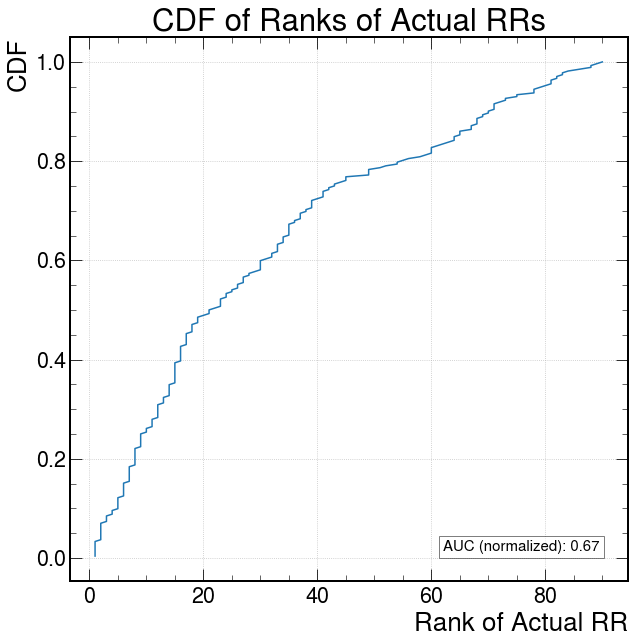

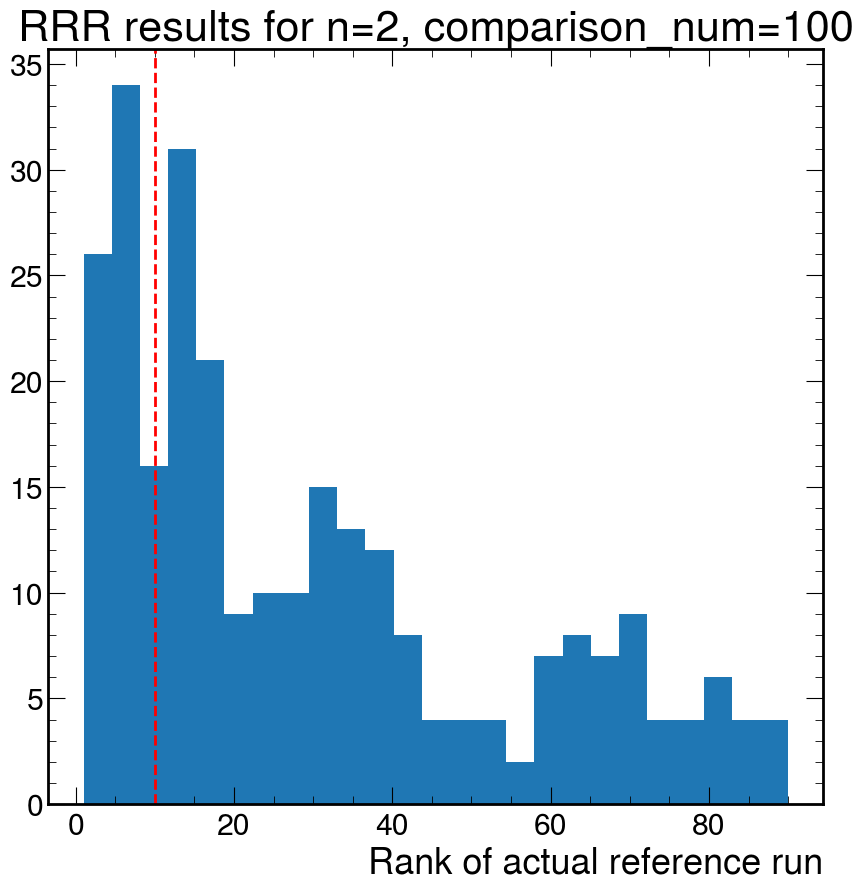

Mean rank of actual RR: 29.74264705882353
Median rank of actual RR: 24.5
Top-k accuracy (k=10): 0.2426470588235294
Mean reciprocal rank: 0.09225148827160229


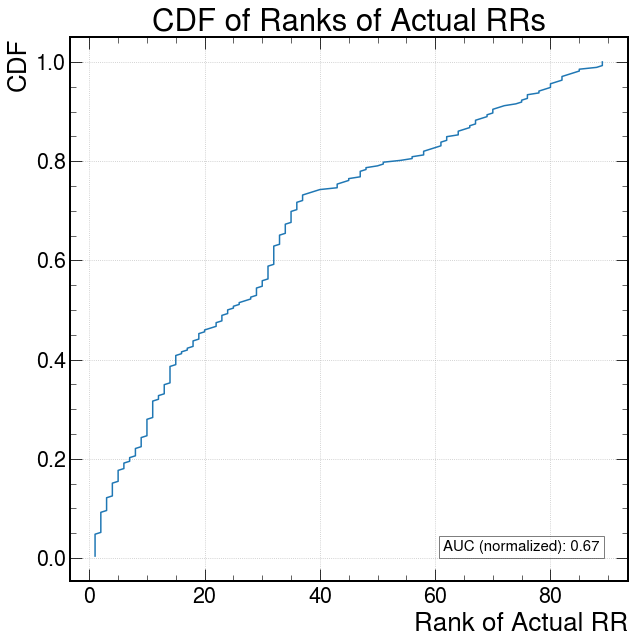

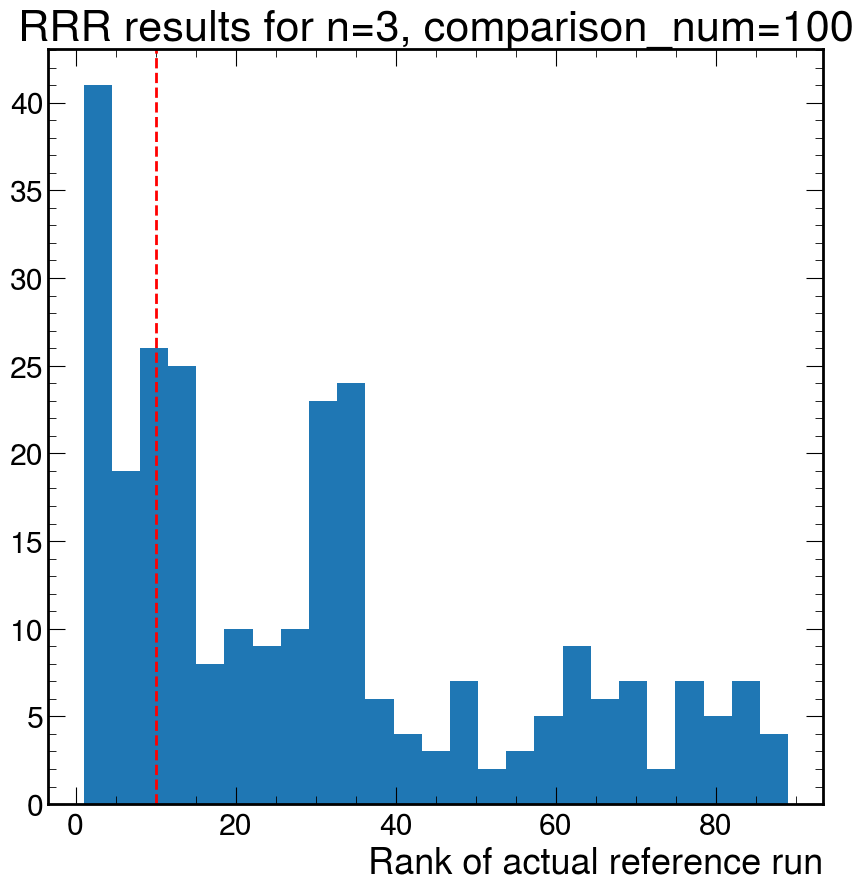

Mean rank of actual RR: 33.036764705882355
Median rank of actual RR: 26.0
Top-k accuracy (k=10): 0.1801470588235294
Mean reciprocal rank: 0.07006422637171761


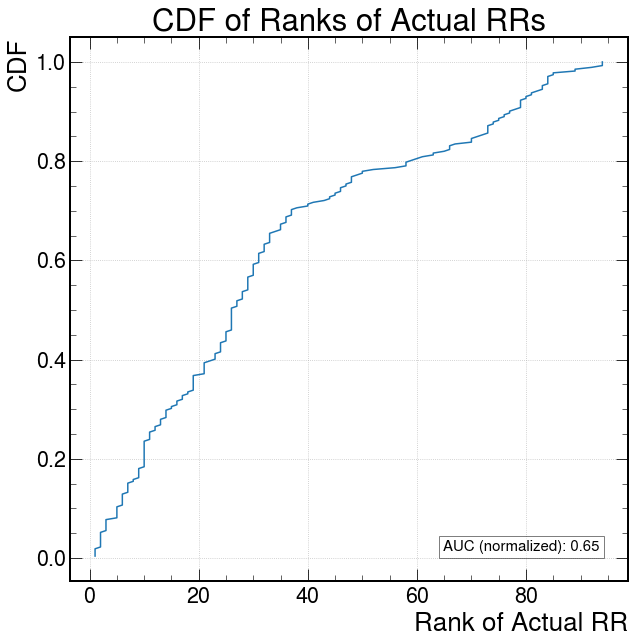

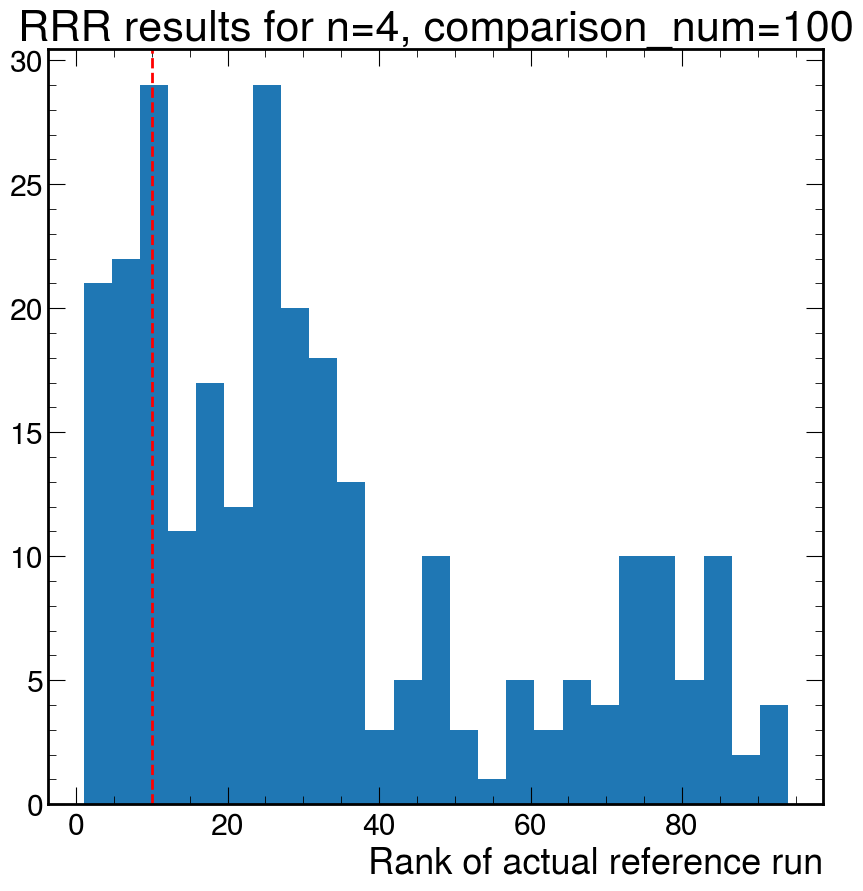

Mean rank of actual RR: 32.9375
Median rank of actual RR: 27.0
Top-k accuracy (k=10): 0.18382352941176472
Mean reciprocal rank: 0.06829547221952209


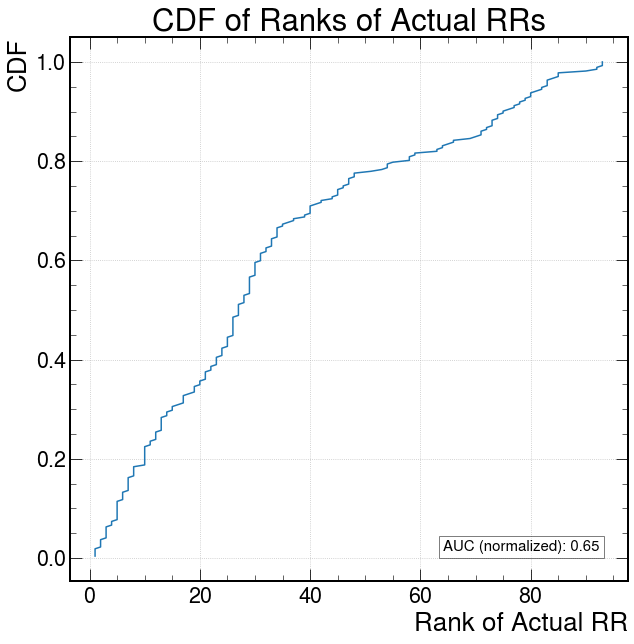

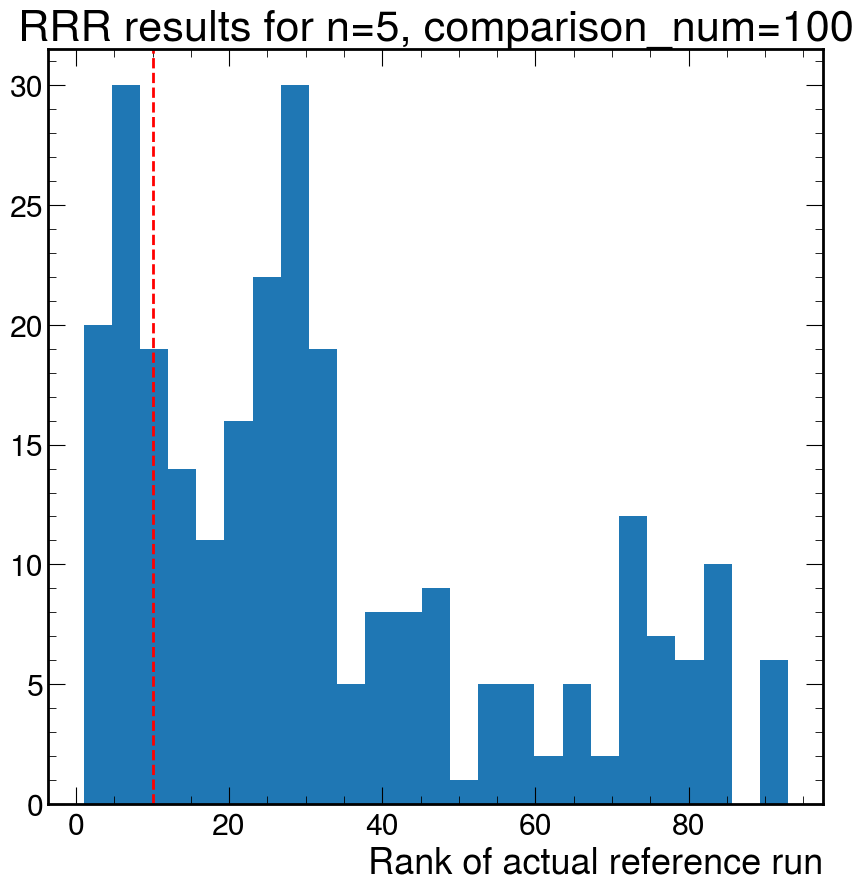

Mean rank of actual RR: 32.286764705882355
Median rank of actual RR: 27.5
Top-k accuracy (k=10): 0.19117647058823528
Mean reciprocal rank: 0.06932601073919088


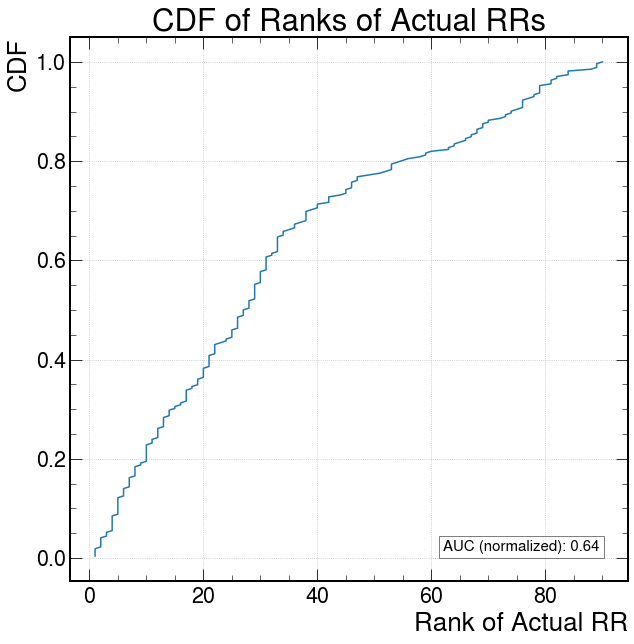

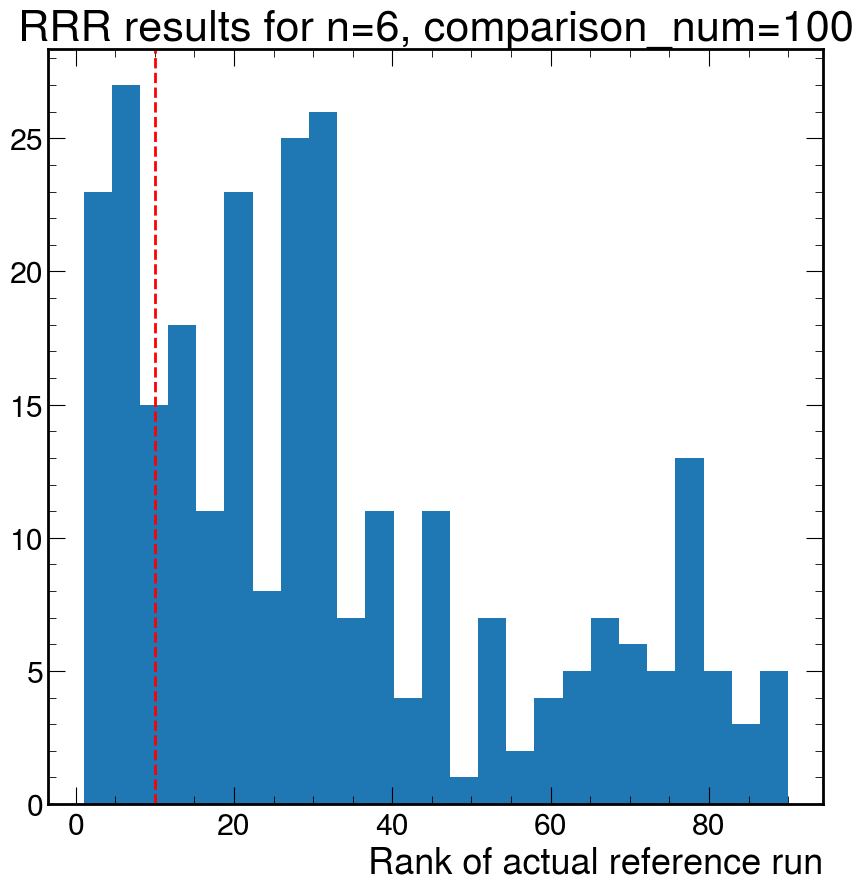

Mean rank of actual RR: 52.91121495327103
Median rank of actual RR: 45.0
Top-k accuracy (k=10): 0.24299065420560748
Mean reciprocal rank: 0.08125261690845709


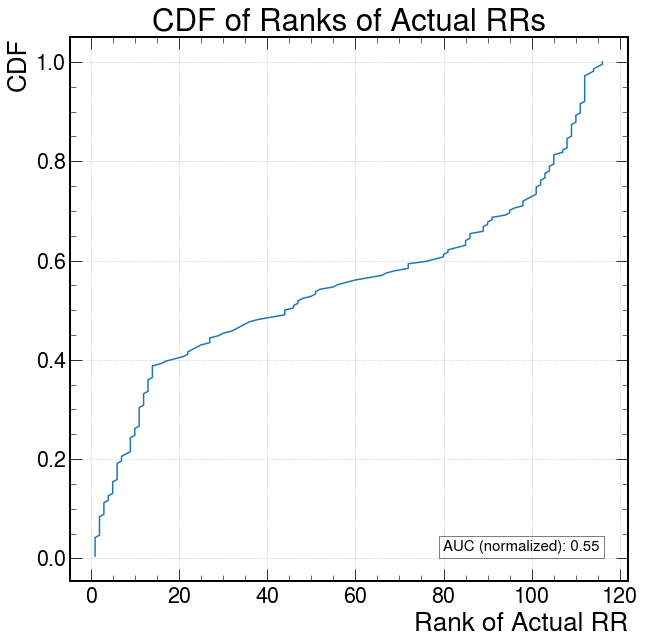

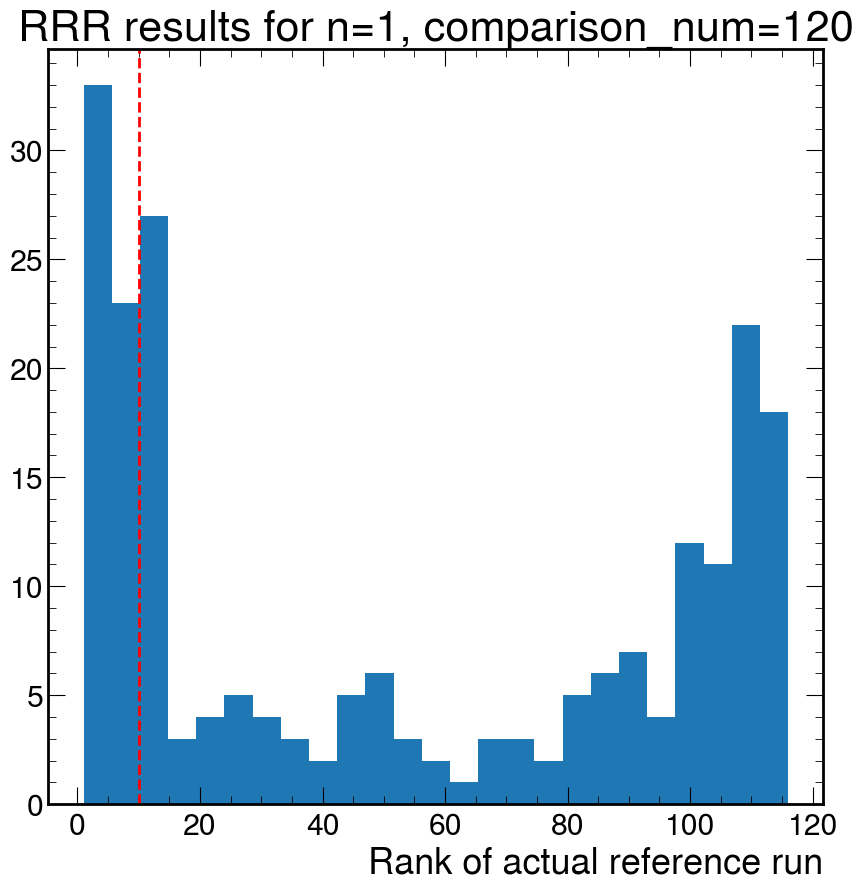

Mean rank of actual RR: 36.799065420560744
Median rank of actual RR: 20.0
Top-k accuracy (k=10): 0.2850467289719626
Mean reciprocal rank: 0.09539056895633165


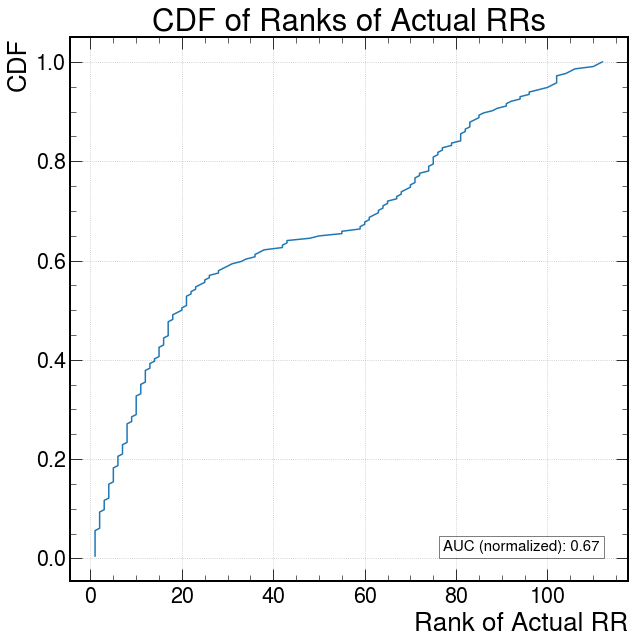

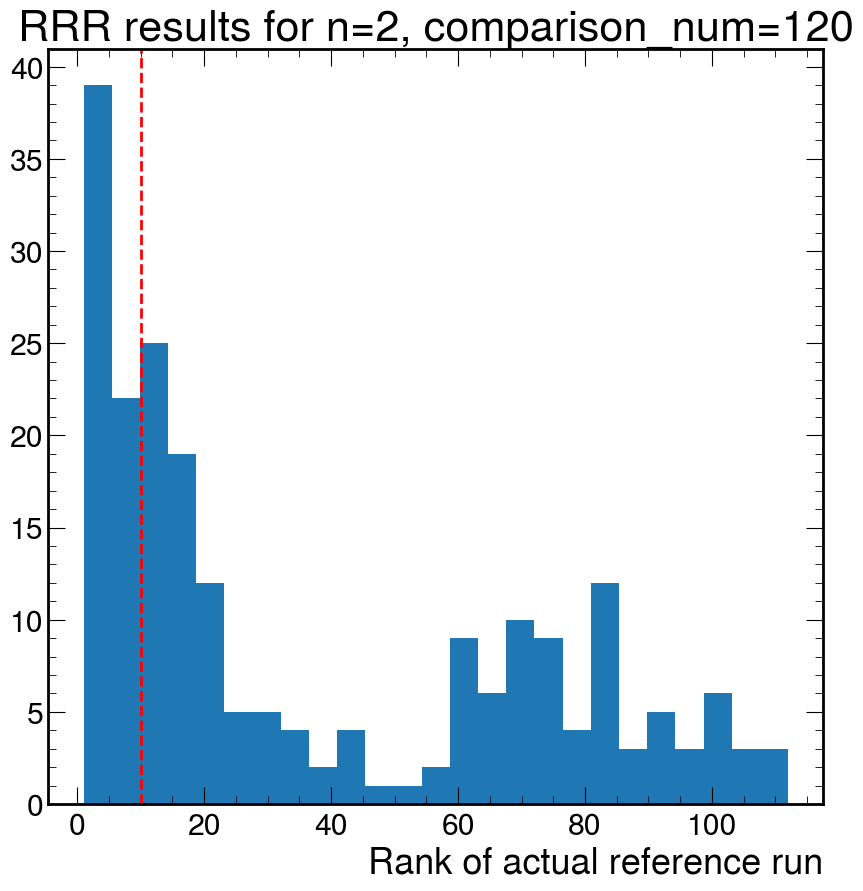

Mean rank of actual RR: 35.271028037383175
Median rank of actual RR: 17.0
Top-k accuracy (k=10): 0.32710280373831774
Mean reciprocal rank: 0.10920226014581173


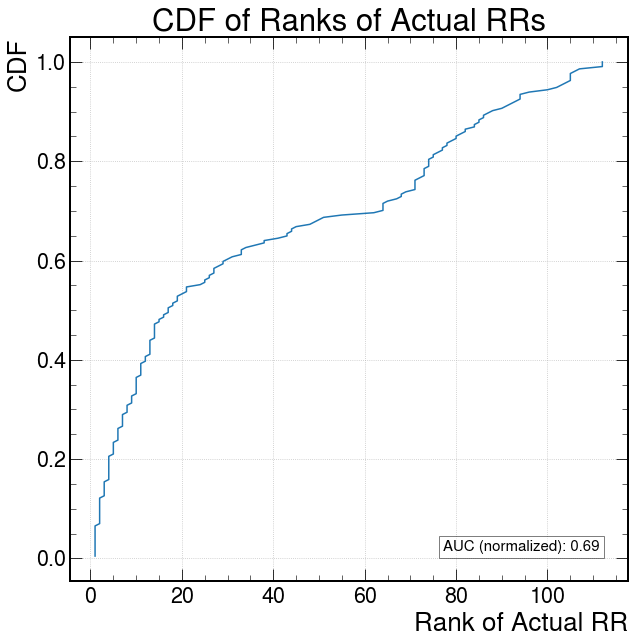

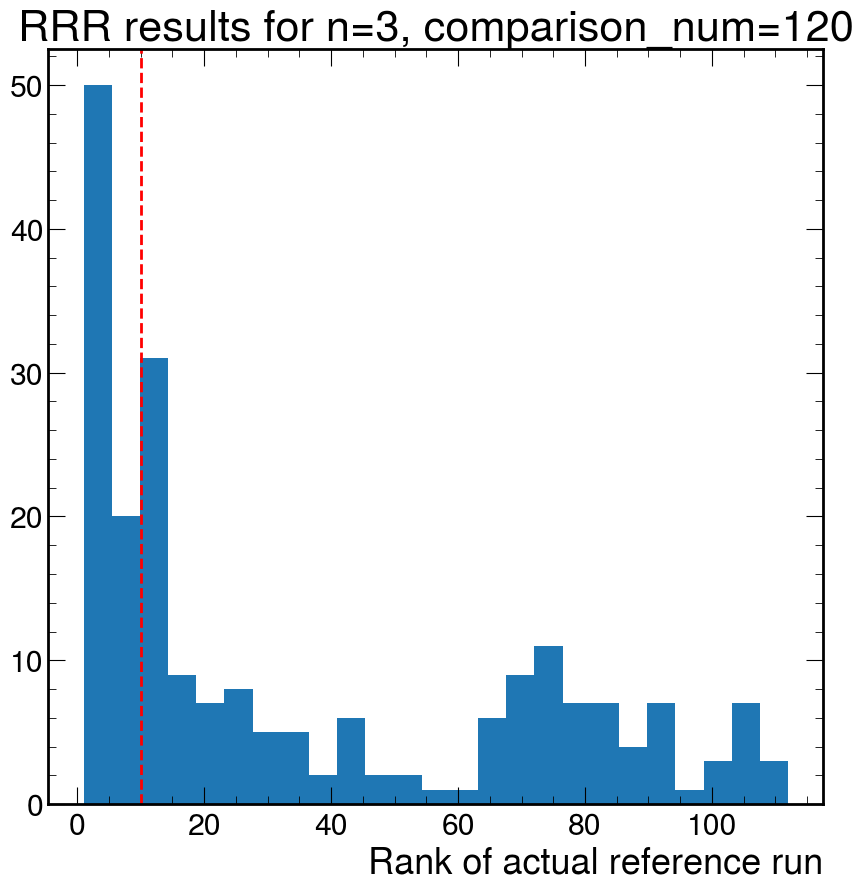

Mean rank of actual RR: 40.91121495327103
Median rank of actual RR: 27.0
Top-k accuracy (k=10): 0.2102803738317757
Mean reciprocal rank: 0.0735609741963661


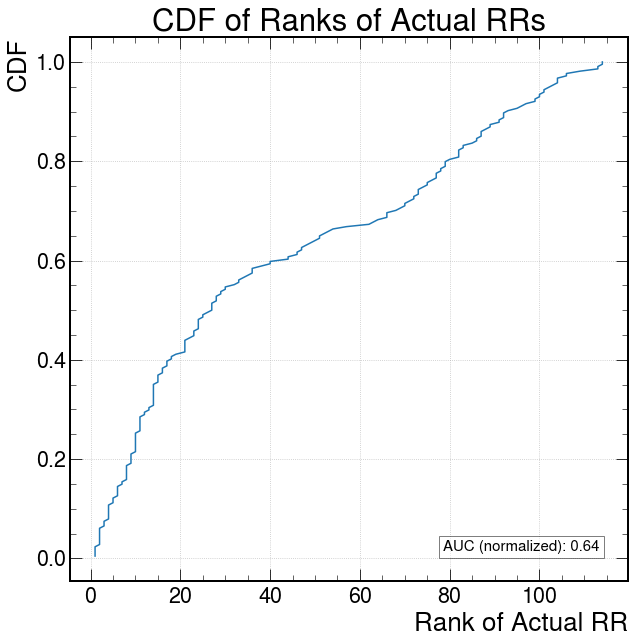

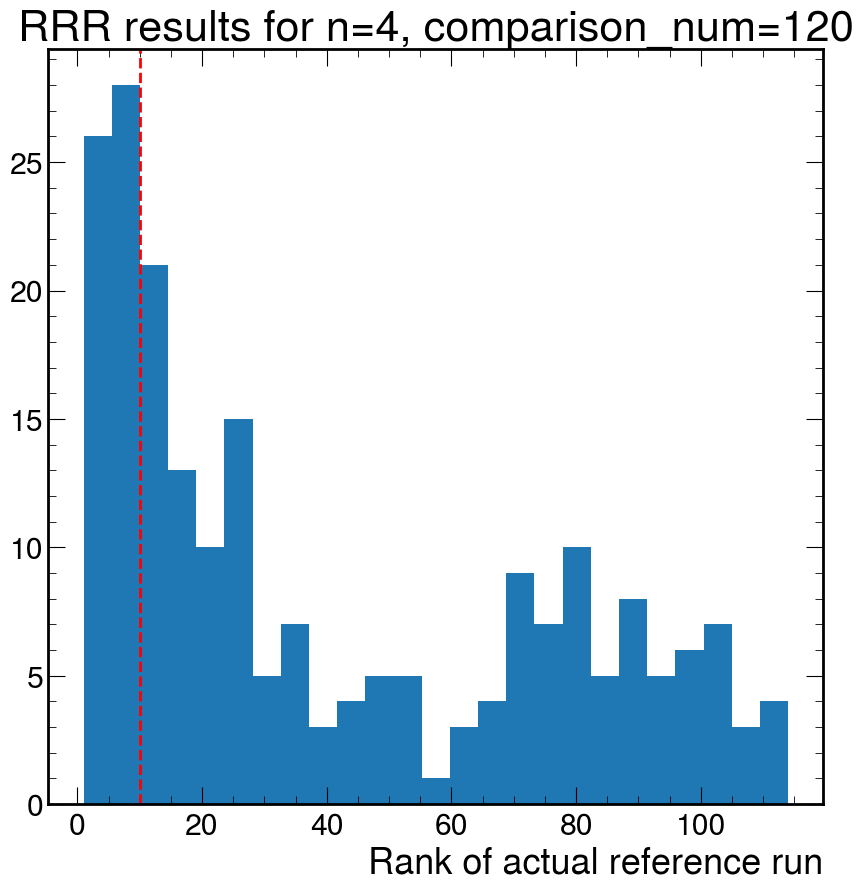

Mean rank of actual RR: 40.995327102803735
Median rank of actual RR: 28.0
Top-k accuracy (k=10): 0.22429906542056074
Mean reciprocal rank: 0.06810816162624483


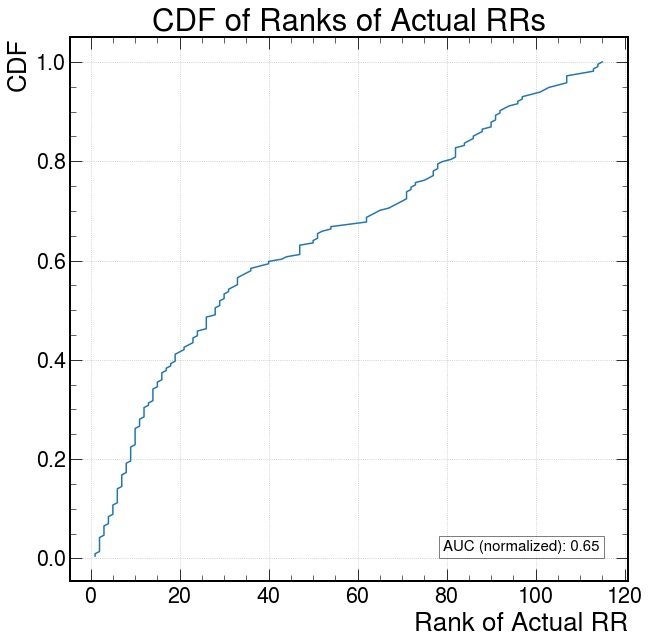

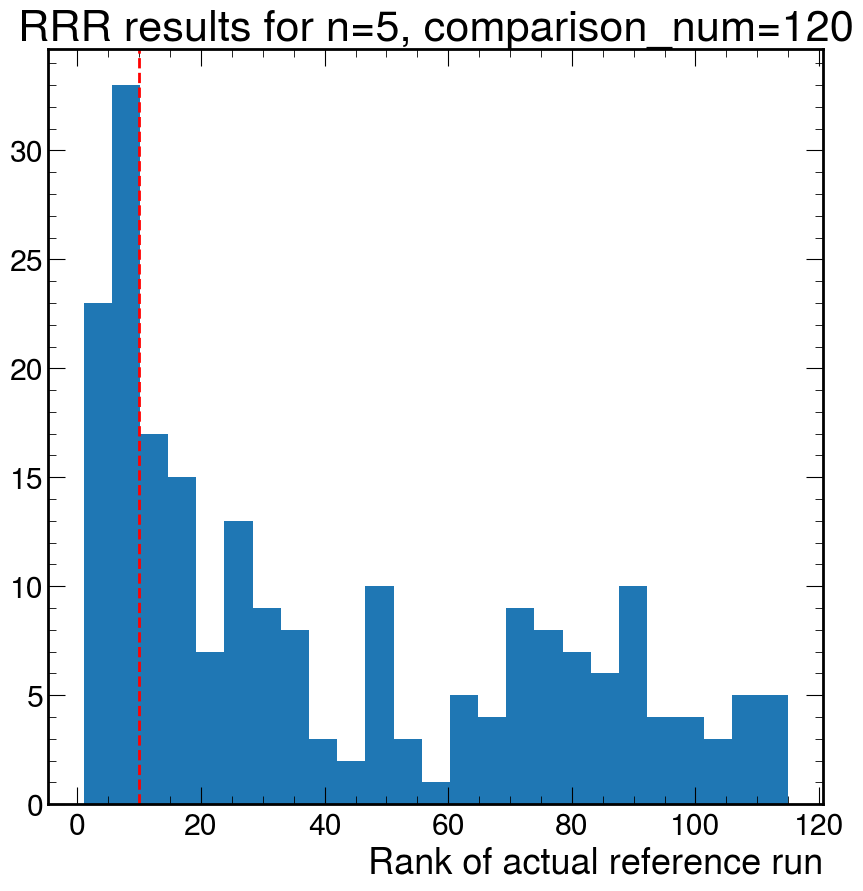

Mean rank of actual RR: 40.32710280373832
Median rank of actual RR: 27.0
Top-k accuracy (k=10): 0.19626168224299065
Mean reciprocal rank: 0.06954011247674807


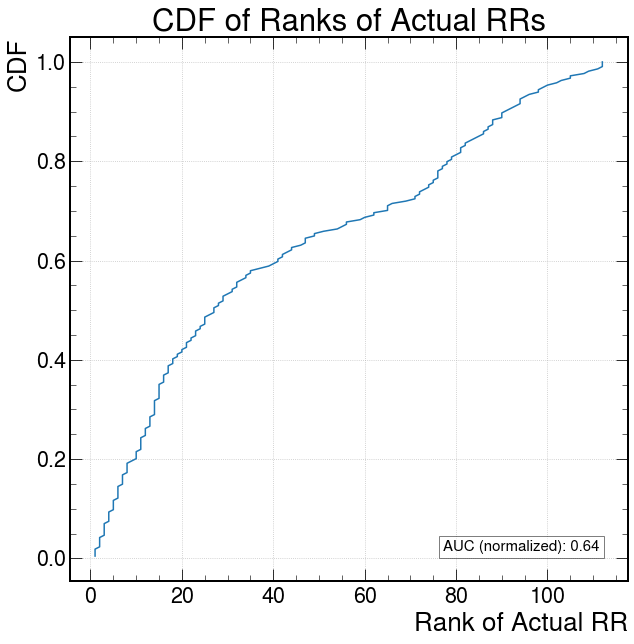

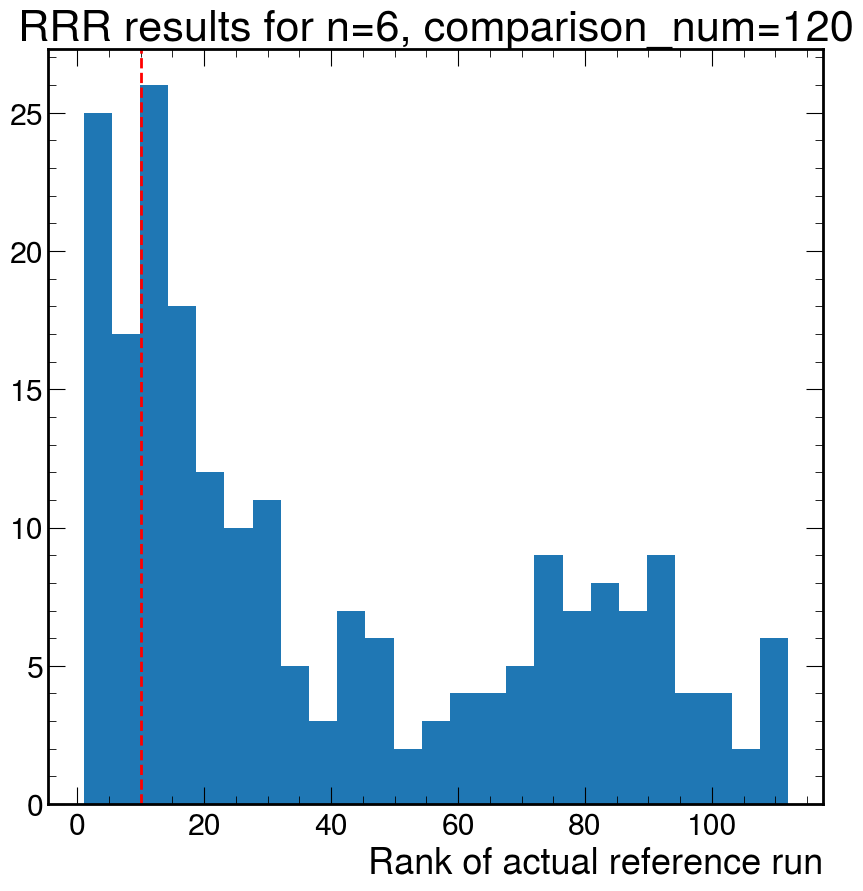

In [178]:
for comparisons, components in product(comp_number_range, n_components_range):
    RRranks = test_rank(
        targets_wRR, 
        candidates_df, 
        comp_number=comparisons, 
        n_components=components, 
        print_stats=True, 
        plot=True, 
        dpi=100, 
        return_RRranks=True
    )